<a href="https://colab.research.google.com/github/ekariba/datasetgeneration/blob/main/Dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal sarcasm dataset generation for a low resource language: Swahili

Objectives
Generate a multimodal sarcasm dataset for a low resource language, Swahili, validate it and finetune it using another opensource model.

- Dataset creation and validation
- Use the model to finetune another opensource model


Model selection and planning

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd


In [ ]:
import base64
from openai import OpenAI

client = OpenAI(
    api_key='')


# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [ ]:

def process_images_in_directory(directory_path, batch_size=5):
    image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if
                   f.lower().endswith((".png", ".jpg", ".jpeg"))]

    batches = [image_files[i:i + batch_size] for i in range(0, len(image_files), batch_size)]

    all_captions = []

    for batch in batches:
        encoded_images_dict = [{"id": os.path.basename(image_path), "data": encode_image(image_path)} for image_path in
                               batch]

        # Generate captions for the batch
        captions = generate_caption(encoded_images_dict)
        all_captions.extend(captions)

    return all_captions


def parse_sentences(response_content):
    # Ensure response_content is a string
    if isinstance(response_content, list):
        response_content = response_content[0][1]  # Extract the 'content' string from the list of tuples

    # Split the content into lines
    lines = response_content.split("\n")

    # Remove numbering and quotes, and return clean sentences
    sentences = [
        line.split(". ", 1)[-1].strip(' "')
        for line in lines
        if line.strip()  # Ensure the line is not empty
    ]

    return sentences


def generate_caption(encoded_images_dict):
    # Prepare the message content with multiple images
    message_content = [
        {
            "type": "text",
            "text": "Generate a sarcastic caption in Swahili for each of these images without any additional text."
                    "Generate a sarcastic caption in english for each of these images without any additional text.",
        }
    ]

    for base64_image in encoded_images_dict:
        message_content.append(
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64 row['data']}"},
            }
        )

    # Send the message with all images
    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {
                "role": "user",
                "content": message_content,
            },
        ],
    )

    # Extract captions for each image from the response
    captions = response.choices[0].message

    return captions


response = process_images_in_directory("images", batch_size=5)
print(response)


[]


In [ ]:
import pandas as pd

# Extract content
content = next(item[1] for item in response if item[0] == 'content')

rows = []
for entry in content.split("\n\n"):
    if not entry.strip():
        continue
    parts = entry.split("**English:**")
    swahili = parts[0].split("**Swahili:**")[1].strip().strip('"')
    english = parts[1].strip().strip('"') if len(parts) > 1 else None
    rows.append({'Swahili': swahili, 'English': english})

# Create a DataFrame
df = pd.DataFrame(rows)

# Display DataFrame
df_swahili = df[['Swahili']].copy()
df_english = df[['English']].copy()




,Swahili
0,Nafasi bora ya kupumzikia plastiki.
1,"Wanaendesha baiskeli ndani ya mvua ya moshi, w..."
2,Uwanja mzuri wa michezo wa kata ya miti.
3,"Upeo mzuri wa mandhari, si unavyofikiri?"
4,"Kisiwa chako kilichopendekezwa, kwa kuogelea m..."


In [ ]:
df_english.head()

,English
0,What a lovely place to relax with all this pla...
1,Cycling through a smoke cloud? What a refreshi...
2,Perfect sports field with all these tree stumps!
3,"What a beautiful waterfront view, don’t you th..."
4,"Your recommended island getaway, complete with..."


In [ ]:
df_swahili.head()

,Swahili
0,Nafasi bora ya kupumzikia plastiki.
1,"Wanaendesha baiskeli ndani ya mvua ya moshi, w..."
2,Uwanja mzuri wa michezo wa kata ya miti.
3,"Upeo mzuri wa mandhari, si unavyofikiri?"
4,"Kisiwa chako kilichopendekezwa, kwa kuogelea m..."


Criteria

We will review the quality of the captions using the criteria below

**Relevance 1 to 4**

> 1. The caption is not relevant to the image
> 2. The caption recognises the context of the image but is unrelated
> 3. The caption is relevant to the image and contextually relevant
> 4. The caption is very relevant

**Sarcasm Creativity 1 to 3**
> 1. The caption is not creative
> 2. The caption is creative
> 3. The caption's creativity is excellent

**Grammatical correctness 1 to 3**
> 1. The caption has grammar errors and is incoherent
> 2. The caption has grammar errors but is understandable
> 3. The caption is grammatically correct

Reviewing the results

In [ ]:
# English captions
df_english['Relevance'] = ['3', '4', '4', '2', '4']
df_english['Sarcasm Creativity'] = ['2', '3', '3', '3', '3']
df_english['Grammatical Correctness'] = ['2', '3', '3', '3', '3']

# Swahili captions
df_swahili['Relevance'] = ['3', '3', '3', '2', '3']
df_swahili['Sarcasm Creativity'] = ['2', '2', '3', '3', '3']
df_swahili['Grammatical Correctness'] = ['2', '2', '2', '2', '2']

In [ ]:
df_swahili.head()

,Swahili,Relevance,Sarcasm Creativity,Grammatical Correctness
0,Nafasi bora ya kupumzikia plastiki.,3,2,2
1,"Wanaendesha baiskeli ndani ya mvua ya moshi, w...",3,2,2
2,Uwanja mzuri wa michezo wa kata ya miti.,3,3,2
3,"Upeo mzuri wa mandhari, si unavyofikiri?",2,3,2
4,"Kisiwa chako kilichopendekezwa, kwa kuogelea m...",3,3,2


In [ ]:
df_english.head()

,English,Relevance,Sarcasm Creativity,Gramatical Correctness,Grammatical Correctness
0,What a lovely place to relax with all this pla...,3,2,2,2
1,Cycling through a smoke cloud? What a refreshi...,4,3,3,3
2,Perfect sports field with all these tree stumps!,4,3,3,3
3,"What a beautiful waterfront view, don’t you th...",2,3,3,3
4,"Your recommended island getaway, complete with...",4,3,3,3


An analysis of the captions generated reveals that the english captions are of a higher quality than the swahili captions. We conclude that the api will be more relevant and creative at generating english captions

## Initial Data Preparation

#### Data collection

Images were collected randomly from multiple datasets into 9 categories. These were drought, landslide, air pollution, no air pollution, water damage, sea, plastic pollution, forest wildfire and forest. We will generate captions for this sample, which we shall use to optimise the generation parameters for the final task.

Generate caption with metadata

In [ ]:
import csv
import json


def generate_caption_with_metadata(encoded_images_dict, parameters=None):
    # Default parameters
    default_parameters = {
        "temperature": 0.7,
        "max_tokens": 500,
        "top_p": 0.9,
        "frequency_penalty": 0.1,
        "presence_penalty": 0.1,
    }

    # Merge default parameters with user-provided parameters (if any)
    if parameters is None:
        parameters = default_parameters
    else:
        parameters = {**default_parameters, **parameters}
    # This is the system instruction to produce ONLY valid JSON with the specified structure.
    system_instruction = """
    You are ChatGPT. When you respond, produce only valid JSON with the following structure:

        {
          "image_id": "string",
          "sarcastic_caption": "string",
          "neutral_caption": "string",
          "positive_caption": "string",
          "negative_caption": "string",
          "tags": "string, string"
        },
        {
          "image_id": "string",
          "sarcastic_caption": "string",
          "neutral_caption": "string",
          "positive_caption": "string",
          "negative_caption": "string",
          "tags": "string, string"
        }

    Do not include any additional fields or text. Only return this JSON structure.
    """
    # Prepare the message content with multiple images
    message_content = [
        {
            "type": "text",
            "text": "Generate a sarcastic caption in English for each of these images, on an environmental theme, enclosed in double quotation marks and without any additional text. \
                    - The caption should be very creative.\
                    - The caption should be unique and different from the previous one.\
                    - The caption should be contextually related to the image.\
                    - The caption should be at least 15 words long."
        },
        {
            "type": "text",
            "text": "Generate a string of keywords(tags) describing the image. Each tag should be a complete phrase or word, properly formatted, and separated by a single comma and a space "
                    "(e.g., 'drought, dry, cracked earth, landscape'). Ensure there are no extra spaces, characters, or splitting of individual letters."
        },
        {
            "type": "text",
            "text": "Generate a neutral sentiment caption in English for each of these images, on an environmental theme, enclosed in double quotation marks and without any additional text.The caption should be at least 15 words long."
        },
        {
            "type": "text",
            "text": "Generate a positive sentiment caption in English for each of these images, on an environmental theme, enclosed in double quotation marks and without any additional text.The caption should be at least 15 words long."
        },
        {
            "type": "text",
            "text": "Generate a negative sentiment caption in English for each of these images, on an environmental theme, enclosed in double quotation marks and without any additional text.The caption should be at least 15 words long."
        },
    ]

    for base64_image in encoded_images_dict:
        message_content.append(
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image['data']}"}
            },
        )
        message_content.append(
            {
                "type": "text",
                "text": f"Prefix the response with the content: {base64_image['id']}"
            }
        )
        message_content.append(
            {
                "type": "text",
                "text": f"The prefix in the image id is related to the topic: {base64_image['id']}"
            },
        )

    try:
        # Send the message with all images
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are an assistant who generates a description and sarcastic caption of images of environmental topics such as pollution, climate change, global warming, deforestation, climate related disaster events, etc.",
                },
                {
                    "role": "system",
                    "content": system_instruction
                },
                {
                    "role": "user",
                    "content": message_content,
                },

            ],
            temperature=parameters["temperature"],
            # max_tokens=parameters["max_tokens"],
            top_p=parameters["top_p"],
            frequency_penalty=parameters["frequency_penalty"],
            presence_penalty=parameters["presence_penalty"],
        )
        # Extract captions for each image from the response
        captions = response.choices[0].message
        return captions
    except Exception as e:
        print(f"{e}")
        return None


def get_image_name(directory_path, image_path):
    image_name = os.path.basename(os.path.basename(directory_path) + '_' + os.path.basename(image_path))
    return image_name


def get_content_only(data):
    content_list = []
    for key, value in data:
        if key == 'content' and value is not None and value.index('caption') != -1:
            response = value.split("```")[1].replace("json", "") if value.startswith("```") else value
            content_list.append(response)
    return content_list


def process_images_in_directory_with_metadata(images_directory, batch_size=5, parameters=None):
    all_captions = []
    for category in os.listdir(images_directory):
        directory_path = os.path.join(images_directory, category)
        if os.path.isdir(directory_path):
            image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if
                           f.lower().endswith((".png", ".jpg", ".jpeg"))]

            batches = [image_files[i:i + batch_size] for i in range(0, len(image_files), batch_size)]

            for batch in batches:
                encoded_images_dict = [
                    {"id": get_image_name(directory_path, image_path), "data": encode_image(image_path)} for image_path
                    in
                    batch]

                # Generate captions for the batch
                captions = generate_caption_with_metadata(encoded_images_dict, parameters)
                if captions is not None:
                    caption_content = get_content_only(captions)
                    if caption_content is not None:
                        all_captions.extend(caption_content)

    return all_captions


def write_to_file(content, file_name="output_swahili_temp.csv"):
    all_images = []
    # 1. Parse each JSON string and extend our all_images list
    for category_content in content:
        if category_content is not None and len(category_content) > 0:
            content_as_json = None
            try:
                content_as_json = json.loads(category_content)
            except Exception as e:
                print(f"Could not process: {e}  {category_content}")
                break
            else:
                if "images" in content_as_json:
                    for img in content_as_json["images"]:
                        all_images.append(img)

        # 2. Define the CSV column headers
        fieldnames = ["image_id", "sarcastic_caption", "neutral_caption", "positive_caption", "tags"]

        # 3. Write to CSV
        with open(file_name, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for image in all_images:
                try:
                    writer.writerow({
                        "image_id": image["image_id"],
                        "sarcastic_caption": image["sarcastic_caption"],
                        "neutral_caption": image["neutral_caption"],
                        "positive_caption": image["positive_caption"],
                        "negative_caption": image["negative_caption"],
                        "tags": image["tags"]
                    })
                except Exception as e:
                    print(f"Error printing to csv: {e}")

# response = process_images_in_directory_with_metadata("images/sample", batch_size=5)

In [ ]:
# write_to_file(response)

### Using Baseline parameters

Using openapi baseline parameters, captions and descriptions were generated for 44 images. The captions were the evaluated using the cretira descibe above, for relevance amnd Sarcasm creativity as describe above. We did not evaluate them for grammar as the grammar was consistent.

The average relevance of the captions was`3.577778` and Sarcastic creativity `2.64444` as shown below.

In [ ]:
df = pd.read_csv("baseline_params_output_english.csv")

df.tail(10)

,image_id,sarcastic_caption,normal_caption,tags,Relevance,Sarcasm Creativity
36,plastic_pollution_Plastic-Pollution_original_p...,Who needs clear waters when you can have a sal...,A close-up of a water body contaminated with p...,"water, pollution, plastic, environment",4.000000,3.000000
37,plastic_pollution_Plastic-Pollution_original_p...,"Nature called; it wants its beauty back, but w...",An expansive view of a massive area covered in...,"ocean, plastic, pollution, environment",4.000000,2.000000
38,plastic_pollution_Plastic-Pollution_original_p...,Look at all that 'eco-friendly' decor – it's a...,A dense accumulation of plastic waste floating...,"pollution, water, plastic, environment",4.000000,3.000000
39,plastic_pollution_Plastic-Pollution_original_p...,Welcome to the exclusive marine club – members...,A detailed view of the ocean surface covered i...,"plastic, pollution, ocean, environment",4.000000,3.000000
40,no_water_damage_06_04_1927.png,"Ah yes, nothing says beach day like ominous gr...",A rocky shoreline under cloudy skies with wave...,"ocean, waves, cloudy, shoreline",4.000000,2.000000
41,no_water_damage_06_04_1926.png,"Oh great, another deserted paradise. Just what...",A calm turquoise sea with a boat on the sandy ...,"beach, turquoise, boat, calm",4.000000,2.000000
42,no_water_damage_06_04_1924.png,Beautiful sunset! Who cares about rising sea l...,A stunning sunset reflecting on the waves of t...,"sunset, ocean, waves, reflection",4.000000,3.000000
43,no_water_damage_06_04_1925.png,Because who wouldn't want their fishing boat s...,A fishing boat slowly navigating through the m...,"fishing, boat, fog, misty",4.000000,3.000000
44,no_water_damage_06_04_1923.png,This looks like a fleet ready for a beach vaca...,An aerial view of multiple ships sailing in a ...,"ships, ocean, fleet, aerial",4.000000,3.000000
45,SUMMARY,"""""","""""","""""",3.577778,2.644444



### Parameter optimisation

We consider the following parameters for optimisation:

1. Temperature

>*Effect*: Controls randomness in output.
> Low temperature (e.g., 0.2) → Focused, deterministic captions.
>
> High temperature (e.g., 0.8) → Diverse, creative captions.
>
> Optimization: For sarcasm, higher temperatures may yield better results since it requires creativity.

2. Top-p (Nucleus Sampling)

>*Effect*: Controls the range of words considered at each step.
>
> Lower values (e.g., 0.1) → Conservative, precise outputs.
>
> Higher values (e.g., 0.9) → More diverse outputs.
>
> Optimization: Test with values between 0.7 and 0.95 to strike a balance between diversity and relevance.
>
3. Max Tokens
>*Effect*: Limits the length of generated captions.

4. Frequency and Presence Penalty
>Frequency Penalty: Penalizes frequent word repetition.
>
>Presence Penalty: Encourages introducing new words.

#### Parameter optmization implementation

In [ ]:
import csv
import json
from itertools import chain


def flatten_chain(matrix):
    return list(chain.from_iterable(matrix))


def write_to_csv_file(content, file_name="output_swahili_temp.csv"):
    data = json.loads(content)
    all_images = []
    for category_content in data:
        if category_content is not None and len(category_content) > 0:
            all_images.append(category_content)

    fieldnames = ["image_id", "sarcastic_caption", "neutral_caption", "positive_caption", "negative_caption", "tags"]

    with open(file_name, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for image in all_images:
            try:
                tags = image["tags"].replace('"', '')
                if not (tags.startswith('"') and tags.endswith('"')):
                    tags = f'"{tags}"'

                sarcastic_caption = image["sarcastic_caption"]
                if not (sarcastic_caption.startswith('"') and sarcastic_caption.endswith('"')):
                    sarcastic_caption = f'"{sarcastic_caption}"'

                neutral_caption = image["neutral_caption"]
                if not (neutral_caption.startswith('"') and neutral_caption.endswith('"')):
                    neutral_caption = f'"{neutral_caption}"'

                positive_caption = image["positive_caption"]
                if not (positive_caption.startswith('"') and positive_caption.endswith('"')):
                    positive_caption = f'"{positive_caption}"'

                negative_caption = image["negative_caption"]
                if not (negative_caption.startswith('"') and negative_caption.endswith('"')):
                    negative_caption = f'"{negative_caption}"'

                writer.writerow({
                    "image_id": image["image_id"],
                    "sarcastic_caption": sarcastic_caption,
                    "neutral_caption": neutral_caption,
                    "positive_caption": positive_caption,
                    "negative_caption": negative_caption,
                    "tags": tags,
                })
            except Exception as e:
                print(f"Error printing to csv: {e}")


def write_raw_response_to_file(content, filename):
    try:
        if not isinstance(content, str):
            content = str(content)
        with open(filename, "w", encoding="utf-8") as file:
            file.write(content)
    except Exception as e:
        print(e)


def clean_response(content):
    content_as_string = str(content)
    newlines_removed_content = content_as_string.replace("\\n", "")
    quote_removed = newlines_removed_content.replace("\\'", "")
    slash_removed = quote_removed.replace("\\", "")
    opening_tag_removed = slash_removed.replace("['", "[")
    square_braces_removed = opening_tag_removed.replace("']", "]")
    angle_braces_removed = square_braces_removed.replace("}', '{", "}, {")
    mixed_braces_removed_one = angle_braces_removed.replace("}]', '{", "}, {")
    cleaned_content = mixed_braces_removed_one.replace("}', '[{", "}, {")
    return cleaned_content


def make_api_request(parameters, images_dir, output_file_name, batch_size=5):
    response = process_images_in_directory_with_metadata(images_dir, batch_size=batch_size, parameters=parameters)
    # Write the raw response to a file as plain text
    cleaned_response = clean_response(response)
    raw_output_file = output_file_name.replace('.csv', '_raw_output.txt')
    write_raw_response_to_file(cleaned_response, raw_output_file)
    write_to_csv_file(cleaned_response, output_file_name)

In [ ]:
from itertools import product
import time
import openai
from openai import RateLimitError

# Define hyperparameter ranges
temperature = [0.9]
top_p_values = [0.8]
frequency_penalty_values = [0.2]
presence_penalty_values = [0.1]

# Generate all combinations
hyperparameter_combinations = list(product(
    temperature,
    top_p_values,
    frequency_penalty_values,
    presence_penalty_values
))

# Test each combination
results = []
for combination in hyperparameter_combinations:
    temp, top_p, frequency_penalty_values, presence_penalty_values = combination
    parameters = {
        "temperature": temp,
        "top_p": top_p,
        "frequency_penalty": frequency_penalty_values,
        "presence_penalty": presence_penalty_values
    }
    output_file_name = '_'.join(f"{key}{value}" for key, value in parameters.items())
    output_file_name_csv = f"{output_file_name}.csv"
    write_to_file(response, output_file_name_csv)
    try:
        make_api_request(parameters=parameters, images_dir="images/sample-test", output_file_name=output_file_name,
                         batch_size=1)
    except RateLimitError:
        print("Rate limit reached. Retrying in 60 seconds...")
        time.sleep(60)
        make_api_request(parameters=parameters, images_dir="images/sample-test", output_file_name=output_file_name,
                         batch_size=1)


Captions  were generated, varying the parameters. We then evaluated the relevance and creativity of the generated  captions. A high temperature increases creativity. A high top-p also increases the cerativity of the captions. However with too much creativity the captions start to be less relevant to the picture.

We selected the optimal parameters as:
-  Temperate 0.9

- top_p 0.8

-  frequency penalty 0.3
  
- presence penalty 0.2

### Captions generation task

In [ ]:
import time
import openai
from openai import RateLimitError

# captions_output_filename = "/content/drive/My Drive/DataGeneration/captions_output_english_27.csv"
# images_dir = "/content/drive/My Drive/DataGeneration/images/sample"
images_dir = "images/sample"
captions_output_filename = "output_swahili_temp_1.csv"
parameters = {
    "temperature": 0.9,
    "top_p": 0.8,
    "frequency_penalty": 0.3,
    "presence_penalty": 0.2
}

retry_count = 10  # Number of times to retry
retry_delay = 60  # Delay between retries in seconds

for attempt in range(retry_count):
    try:
        make_api_request(parameters=parameters, images_dir=images_dir, output_file_name=captions_output_filename,
                         batch_size=1)
        break
    except RateLimitError:
        if attempt < retry_count - 1:
            print(f"Rate limit reached. Retrying in {retry_delay} seconds... (Attempt {attempt + 1}/{retry_count})")
            time.sleep(retry_delay)
        else:
            print("Rate limit exceeded after multiple attempts. Exiting.")

## Swahili translation

Using openapi, the captions were then translated to swahili. This task will require  a different set of optimised parameters.


We selected the optimal parameters as:
-  Temperate 0.95 to ensure creativity while still maintaining relevance

- top_p(Nucleus Sampling) 0.9 To ensures that the model focuses on the most probable words while still allowing some level of diversity

-  frequency penalty 0.0 A low penalty to prevent the model from repeating similar phrases excessively, which is critical for creative translations
  
- presence penalty 0.0  To encourage the model to introduce fresh ideas or phrasing, which is helpful for generating engaging and idiomatic translations


In [ ]:
import csv
import os

from itertools import chain


def fetch_translations(data_dict, parameters):
    # Default parameters
    default_parameters = {
        "temperature": 0.7,
        "top_p": 0.9,
        "max_tokens": 300,
        "frequency_penalty": 0.1,
        "presence_penalty": 0.1,
    }

    # Merge default parameters with user-provided parameters (if any)
    if parameters is None:
        parameters = default_parameters
    else:
        parameters = {**default_parameters, **parameters}
    # This is the system instruction to produce ONLY valid JSON with the specified structure.
    system_instruction = """
    You are ChatGPT. When you respond, produce only valid JSON with the following structure:

        {
          "image_id": "string",
          "sarcastic_caption": "string",
          "neutral_caption": "string",
          "positive_caption": "string",
          "negative_caption": "string",
          "tags": "string, string"
        },
        {
          "image_id": "string",
          "sarcastic_caption": "string",
          "neutral_caption": "string",
          "positive_caption": "string",
          "negative_caption": "string",
          "tags": "string, string"
        }

    Do not include any additional fields or text. Only return this JSON structure.
    """
    # Prepare the message content with multiple images
    message_content = [
        {
            "type": "text",
            "text": "Translate the 'sarcastic caption' into Swahili. After translating the 'sarcastic caption' into Swahili: \
                        - Review the sentence to ensure it is grammatically correct and flows naturally in Swahili.\
                        - Replace words or structures to enhance creativity and make the sentence sound more polished and professional.\
                        - Ensure the sarcasm and intended tone remain intact.\
                        - Where possible, prefer expressions or idiomatic phrases that are culturally relevant and resonate naturally with Swahili speakers.\
                        - Provide a refined version of the translation with improvements."
        },

        {
            "type": "text",
            "text": "Translate the 'positive caption'  to swahili. After translating the 'positive caption' into Swahili: \
                        - Review the sentence to ensure it is grammatically correct and flows naturally in Swahili.\
                        - Replace words or structures to enhance creativity and make the sentence sound more polished and professional.\
                        - Ensure the message and intended tone remain intact.\
                        - Where possible, prefer expressions or idiomatic phrases that are culturally relevant and resonate naturally with Swahili speakers.\
                        - Provide a refined version of the translation with improvements."
        },
        {
            "type": "text",
            "text": "Translate the 'neutral caption' to swahili. After translating the 'positive caption' into Swahili: \
                        - Review the sentence to ensure it is grammatically correct and flows naturally in Swahili.\
                        - Replace words or structures to enhance creativity and make the sentence sound more polished and professional.\
                        - Ensure the message and intended tone remain intact.\
                        - Where possible, prefer expressions or idiomatic phrases that are culturally relevant and resonate naturally with Swahili speakers.\
                        - Provide a refined version of the translation with improvements."
        },
        {
            "type": "text",
            "text": "Translate the 'tags' to swahili. After translating the 'positive caption' into Swahili: \
                        - Review the sentence to ensure it is grammatically correct and flows naturally in Swahili.\
                        - Replace words or structures to enhance creativity and make the sentence sound more polished and professional.\
                        - Ensure the message and intended tone remain intact.\
                        - Where possible, prefer expressions or idiomatic phrases that are culturally relevant and resonate naturally with Swahili speakers.\
                        - Provide a refined version of the translation with improvements."
        },
    ]

    for data_row in data_dict:
        message_content.append(
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{data_row['image_data']}"}
            },
        )
        message_content.append(
            {
                "type": "text",
                "text": f"Prefix the response with the content: {data_row['image_id']}"
            }
        )
        message_content.append(
            {
                "type": "text",
                "text": f"Sarcastic caption: {data_row['sarcastic_caption']}"
            }
        )
        message_content.append(
            {
                "type": "text",
                "text": f"Neutral caption: {data_row['neutral_caption']}"
            }
        )
        message_content.append(
            {
                "type": "text",
                "text": f"Positive caption: {data_row['positive_caption']}"
            }
        )
        message_content.append(
            {
                "type": "text",
                "text": f"Negative caption: {data_row['negative_caption']}"
            }
        )

        message_content.append(
            {
                "type": "text",
                "text": f"Context description: {data_row['neutral_caption']}  tags: {data_row['tags']}"
            }
        )

    try:
        # Send the message with all images
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are an assistant who reads images and their english captions then translates the captions into grammatically correct swahili captions, of environmental topics such as pollution, climate change, global warming, deforestation, climate related disaster events, etc. Ensure:\
                           - Ensure the captions creativity is maintained. \
                           - Ensure the translation is grammatically correct and flows naturally with Swahili speakers.\
                           - Ensure the json generated is syntactically correct.",
                },
                {
                    "role": "system",
                    "content": system_instruction
                },
                {
                    "role": "user",
                    "content": message_content,
                },

            ],
            temperature=parameters["temperature"],
            top_p=parameters["top_p"],
            frequency_penalty=parameters["frequency_penalty"],
            presence_penalty=parameters["presence_penalty"],
        )
        captions = response.choices[0].message
        return captions
    except Exception as e:
        print(f"{e}")
        return None


def get_content_only(data):
    content_list = []
    for key, value in data:
        if key == 'content' and value is not None and value.index('caption') != -1:
            response = value.split("```")[1].replace("json", "") if value.startswith("```") else value
            content_list.append(response)
    return content_list


def clean_content(content):
    content_as_string = str(content)
    newlines_removed_content = content_as_string.replace("\\n", "")
    quote_removed = newlines_removed_content.replace("\\'", "")
    slash_removed = quote_removed.replace("\\", "")
    opening_tag_removed = slash_removed.replace("['", "[")
    square_braces_removed = opening_tag_removed.replace("']", "]")
    angle_braces_removed = square_braces_removed.replace("}', '{", "}, {")
    mixed_braces_removed_one = angle_braces_removed.replace("}]', '{", "}, {")
    cleaned_content = mixed_braces_removed_one.replace("}', '[{", "}, {")
    return cleaned_content


def get_encoded_image(image_path):
    encoded_image = encode_image(image_path)
    return encoded_image


def loop_through_file(images_directory="sample", english_csv_file_path="source.csv", parameters=None, batch_size=5):
    # Example CSV data (replace with actual file path if necessary)
    csv_file_path = english_csv_file_path

    all_translations = []

    # Read the CSV file and iterate in batches
    try:
        with open(csv_file_path, "r", encoding="utf-8") as csvfile:
            reader = list(csv.DictReader(csvfile))  # Convert reader to a list for indexing
            total_entries = len(reader)

            for i in range(0, total_entries, batch_size):
                batch = reader[i:i + batch_size]
                batch_content = []

                for row in batch:
                    try:
                        image_id = row["image_id"]
                        sub_directory_name = image_id.split('_')[0]
                        image_name_on_file = image_id.replace(f"{sub_directory_name}_", "", 1)
                        image_path = os.path.join(images_directory, sub_directory_name, image_name_on_file)
                        if os.path.exists(image_path):
                            encoded_image = get_encoded_image(image_path)
                            sarcastic_caption = row["sarcastic_caption"]
                            neutral_caption = row["neutral_caption"]
                            positive_caption = row["positive_caption"]
                            negative_caption = row["negative_caption"]
                            tags = row["tags"]
                            batch_content.append({"image_id": image_id, "image_data": encoded_image,
                                                  "sarcastic_caption": sarcastic_caption,
                                                  "neutral_caption": neutral_caption,
                                                  "positive_caption": positive_caption,
                                                  "negative_caption": negative_caption, "tags": tags})
                            translations = fetch_translations(batch_content, parameters)
                            content = get_content_only(translations)
                            all_translations.extend(content)
                        else:
                            print(f"image path does not exist: {image_path}")
                    except Exception as e:
                        print(f"Error iterating over csv :{e}")
        return all_translations

    except Exception as e:
        print(f"{e}")


english_csv_file_path = "/content/drive/My Drive/DataGeneration/generated_captions/captions_output_english_1.csv"
images_directory = "/content/drive/My Drive/DataGeneration/images/final-images"
translations_output_csv = "/content/drive/My Drive/DataGeneration/generated_captions/captions_output_translation_1.csv"
# english_csv_file_path = "sample.csv"
# images_directory = "images/sample"
# translations_output_csv = "cleaned_translations.csv"
parameters = {
    "temperature": 1.0,
    "top_p": 1.0,
    "frequency_penalty": 0.2,
    "presence_penalty": 0.2,
}

raw_content = loop_through_file(images_directory=images_directory, english_csv_file_path=english_csv_file_path,
                                parameters=parameters, batch_size=1)
cleaned_translations_content = clean_content(raw_content)
translations_output_raw = translations_output_csv.replace('.csv', '_raw_translations.txt')
write_raw_response_to_file(cleaned_translations_content, translations_output_raw)
write_to_csv_file(cleaned_translations_content, translations_output_csv)


## Evaluation

We will use a transformer based, two tower approach to evaluate caption generation. This implementation will consist of:
-	VIT model
-	Swahili BERT model




In [ ]:
### Evaluating captions using BertScore, SPICE and Keywords using BLEU

## Research on Evaluating the generated dataset


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, ViTModel
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# --- Constants ---
BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_EPOCHS = 5
MAX_LENGTH = 512
SWAHILI_BERT_MODEL_NAME = "Davlan/bert-base-multilingual-cased-finetuned-swahili"
VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = ""
GOLD_STANDARD_FILE = "gold_swahili.csv"
GENERATED_CAPTIONS_FILE = "output_swahili.csv"
IMAGE_DIR = "images/subset"

### Adversarial Generation approach

In [ ]:
# --- Helper Function ---
def get_image_path(images_directory, image_id):
    sub_directory_name = image_id.split('_')[0]
    image_name_on_file = image_id.replace(f"{sub_directory_name}_", "", 1)
    return os.path.join(images_directory, sub_directory_name, image_name_on_file)


class SarcasmDetectionDataset(Dataset):
    def __init__(self, data, tokenizer, vit_processor, max_len=512):
        self.data = data
        self.tokenizer = tokenizer
        self.vit_processor = vit_processor
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = get_image_path(IMAGE_DIR, item["image_id"])

        # Load and process image
        image = Image.open(image_path).convert("RGB") if os.path.exists(image_path) else Image.new("RGB", (224, 224))
        image = self.vit_processor(image)  # Transform image
        image = image.unsqueeze(0)  # Ensure correct shape for ViT

        # Tokenize text
        sarcastic_inputs = self.tokenizer(
            item["sarcastic_caption"], padding="max_length", truncation=True, max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "sarcastic_input_ids": sarcastic_inputs["input_ids"].squeeze(0),
            "sarcastic_attention_mask": sarcastic_inputs["attention_mask"].squeeze(0),
            "image": image.squeeze(0),  # Ensure correct shape
            "label": torch.tensor(1, dtype=torch.long)  # Sarcastic = 1
        }


# --- Load CSV Data ---
def load_data(file_path):
    return pd.read_csv(file_path)


class SarcasmDetector(nn.Module):
    def __init__(self, text_model_name, vision_model_name, embedding_dim=256, num_labels=2):
        super().__init__()
        self.sw_bert = AutoModel.from_pretrained(text_model_name,
                                                 add_pooling_layer=False)  # ✅ Remove uninitialized pooling layer
        self.vit = ViTModel.from_pretrained(vision_model_name)

        self.text_projection = nn.Linear(self.sw_bert.config.hidden_size, embedding_dim)
        self.image_projection = nn.Linear(self.vit.config.hidden_size, embedding_dim)
        self.fusion = nn.Linear(embedding_dim * 2, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_labels)

    def forward(self, input_ids, attention_mask, image):
        text_output = self.sw_bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        text_embeddings = self.text_projection(text_output)

        # Ensure image input has correct shape (batch_size, 3, 224, 224)
        if image.dim() == 3:
            image = image.unsqueeze(0)

        image_embeddings = self.vit(pixel_values=image).last_hidden_state[:, 0, :]
        image_embeddings = self.image_projection(image_embeddings)

        combined = torch.cat([text_embeddings, image_embeddings], dim=1)
        fused = nn.ReLU()(self.fusion(combined))
        logits = self.classifier(fused)
        return logits


# --- Adversarial Discriminator ---
class SarcasmDiscriminator(nn.Module):
    def __init__(self, embedding_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc2 = nn.Linear(128, 1)  # Binary output: real (1) or fake (0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, features):
        x = nn.ReLU()(self.fc1(features))
        return self.sigmoid(self.fc2(x))


# --- Adversarial Training ---
def train_adversarial(model, discriminator, train_loader, optimizer_model, optimizer_disc, criterion, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        discriminator.train()
        total_loss_model = 0
        total_loss_disc = 0

        for batch in train_loader:
            input_ids = batch["sarcastic_input_ids"].to(DEVICE)
            attention_mask = batch["sarcastic_attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            image = batch["image"].to(DEVICE)

            optimizer_model.zero_grad()
            optimizer_disc.zero_grad()

            # Step 1: Train Sarcasm Detector
            sarcasm_features = model(input_ids=input_ids, attention_mask=attention_mask, image=image)
            sarcasm_logits = model.classifier(sarcasm_features)
            loss_model = criterion(sarcasm_logits, labels)
            loss_model.backward()
            optimizer_model.step()

            # Step 2: Train Discriminator
            real_labels = torch.ones((sarcasm_features.shape[0], 1), device=DEVICE)
            fake_labels = torch.zeros((sarcasm_features.shape[0], 1), device=DEVICE)

            real_loss = criterion(discriminator(sarcasm_features.detach()), real_labels)
            fake_loss = criterion(discriminator(torch.randn_like(sarcasm_features)),
                                  fake_labels)  # Generate random fakes
            loss_disc = (real_loss + fake_loss) / 2

            loss_disc.backward()
            optimizer_disc.step()

            total_loss_model += loss_model.item()
            total_loss_disc += loss_disc.item()

        print(
            f"Epoch {epoch + 1}: Model Loss: {total_loss_model / len(train_loader)}, Discriminator Loss: {total_loss_disc / len(train_loader)}")


# --- Main Execution ---
if __name__ == "__main__":
    gold_standard_data = load_data(os.path.join(DATA_DIR, GOLD_STANDARD_FILE))
    tokenizer = AutoTokenizer.from_pretrained(SWAHILI_BERT_MODEL_NAME)
    vit_processor = transforms.Compose([
        transforms.Resize((224, 224)), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = SarcasmDetectionDataset(gold_standard_data.to_dict("records"), tokenizer, vit_processor)
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Initialize Models
    sarcasm_detector = SarcasmDetector(SWAHILI_BERT_MODEL_NAME, VIT_MODEL_NAME).to(DEVICE)
    discriminator = SarcasmDiscriminator().to(DEVICE)

    optimizer_model = optim.Adam(sarcasm_detector.parameters(), lr=LEARNING_RATE)
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCELoss()

    # Train Models
    train_adversarial(sarcasm_detector, discriminator, train_loader, optimizer_model, optimizer_disc, criterion,
                      NUM_EPOCHS)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, ViTModel
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# --- Constants ---
BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_EPOCHS = 5
MAX_LENGTH = 512
SWAHILI_BERT_MODEL_NAME = "Davlan/bert-base-multilingual-cased-finetuned-swahili"
VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = ""
GOLD_STANDARD_FILE = "gold_swahili.csv"
IMAGE_DIR = "images/subset"


# --- Helper Function ---
def get_image_path(images_directory, image_id):
    sub_directory_name = image_id.split('_')[0]
    image_name_on_file = image_id.replace(f"{sub_directory_name}_", "", 1)
    return os.path.join(images_directory, sub_directory_name, image_name_on_file)


# --- Data Loading ---
class SarcasmDetectionDataset(Dataset):
    def __init__(self, data, tokenizer, vit_processor, max_len=512):
        self.data = data
        self.tokenizer = tokenizer
        self.vit_processor = vit_processor
        self.max_len = max_len

    def __len__(self):
        return len(self.data) * 4  # Each row generates 4 samples (sarcastic, positive, negative, neutral)

    def __getitem__(self, idx):
        row_idx = idx // 4  # Get the original row index
        caption_type = idx % 4  # Determine which caption to use
        item = self.data[row_idx]
        image_path = get_image_path(IMAGE_DIR, item["image_id"])

        # Load and process image
        image = Image.open(image_path).convert("RGB") if os.path.exists(image_path) else Image.new("RGB", (224, 224))
        image = self.vit_processor(image)  # Transform image
        image = image.unsqueeze(0)  # Ensure correct shape for ViT

        # Select caption and label
        if caption_type == 0:
            caption = item["sarcastic_caption"]
            label = 1  # Sarcasm
        elif caption_type == 1:
            caption = item["positive_caption"]
            label = 0  # Not sarcasm
        elif caption_type == 2:
            caption = item["negative_caption"]
            label = 0  # Not sarcasm
        else:
            caption = item["neutral_caption"]
            label = 0  # Not sarcasm

        # Tokenize text
        text_inputs = self.tokenizer(caption, padding="max_length", truncation=True, max_length=self.max_len,
                                     return_tensors="pt")

        return {
            "input_ids": text_inputs["input_ids"].squeeze(0),
            "attention_mask": text_inputs["attention_mask"].squeeze(0),
            "image": image.squeeze(0),
            "label": torch.tensor(label, dtype=torch.float)  # Change dtype to float for BCE loss
        }


# --- Load CSV Data ---
def load_data(file_path):
    return pd.read_csv(file_path)


# --- Two-Tower Sarcasm Detector ---
class SarcasmDetector(nn.Module):
    def __init__(self, text_model_name, vision_model_name, embedding_dim=256):
        super().__init__()
        self.sw_bert = AutoModel.from_pretrained(text_model_name, add_pooling_layer=False)
        self.vit = ViTModel.from_pretrained(vision_model_name)

        self.text_projection = nn.Linear(self.sw_bert.config.hidden_size, embedding_dim)
        self.image_projection = nn.Linear(self.vit.config.hidden_size, embedding_dim)
        self.fusion = nn.Linear(embedding_dim * 2, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, 1)  # Binary classifier

    def forward(self, input_ids, attention_mask, image, return_features=False):
        text_output = self.sw_bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        text_embeddings = self.text_projection(text_output)

        if image.dim() == 3:
            image = image.unsqueeze(0)

        image_embeddings = self.vit(pixel_values=image).last_hidden_state[:, 0, :]
        image_embeddings = self.image_projection(image_embeddings)

        combined = torch.cat([text_embeddings, image_embeddings], dim=1)
        fused = nn.ReLU()(self.fusion(combined))

        if return_features:
            return fused  # Return embeddings for discriminator

        logits = torch.sigmoid(self.classifier(fused))  # Convert logits to probabilities
        return logits


# --- Adversarial Discriminator ---
class SarcasmDiscriminator(nn.Module):
    def __init__(self, embedding_dim=256):  # Match sarcasm detector's output embedding size
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)  # Input size matches sarcasm detector's output
        self.fc2 = nn.Linear(128, 1)  # Binary output: real (1) or fake (0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, features):
        x = nn.ReLU()(self.fc1(features))
        return self.sigmoid(self.fc2(x))


# --- Adversarial Training ---
def train_adversarial(model, discriminator, train_loader, optimizer_model, optimizer_disc, criterion, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        discriminator.train()
        total_loss_model = 0
        total_loss_disc = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["label"].unsqueeze(1).to(DEVICE)  # Ensure labels have correct shape
            image = batch["image"].to(DEVICE)

            optimizer_model.zero_grad()
            optimizer_disc.zero_grad()

            # Step 1: Train Sarcasm Detector
            sarcasm_features = model(input_ids=input_ids, attention_mask=attention_mask, image=image,
                                     return_features=True)
            sarcasm_logits = model.classifier(sarcasm_features)
            loss_model = criterion(torch.sigmoid(sarcasm_logits), labels)
            loss_model.backward()
            optimizer_model.step()

            # Step 2: Train Discriminator
            real_labels = torch.ones((sarcasm_features.shape[0], 1), device=DEVICE)
            fake_labels = torch.zeros((sarcasm_features.shape[0], 1), device=DEVICE)

            real_loss = criterion(discriminator(sarcasm_features.detach()), real_labels)
            fake_loss = criterion(discriminator(torch.randn_like(sarcasm_features)),
                                  fake_labels)  # Generate random fakes
            loss_disc = (real_loss + fake_loss) / 2

            loss_disc.backward()
            optimizer_disc.step()

            total_loss_model += loss_model.item()
            total_loss_disc += loss_disc.item()

        print(
            f"Epoch {epoch + 1}: Model Loss: {total_loss_model / len(train_loader)}, Discriminator Loss: {total_loss_disc / len(train_loader)}")


# --- Main Execution ---
if __name__ == "__main__":
    gold_standard_data = load_data(os.path.join(DATA_DIR, GOLD_STANDARD_FILE))
    tokenizer = AutoTokenizer.from_pretrained(SWAHILI_BERT_MODEL_NAME)
    vit_processor = transforms.Compose([
        transforms.Resize((224, 224)), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = SarcasmDetectionDataset(gold_standard_data.to_dict("records"), tokenizer, vit_processor)
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Initialize Models
    sarcasm_detector = SarcasmDetector(SWAHILI_BERT_MODEL_NAME, VIT_MODEL_NAME).to(DEVICE)
    discriminator = SarcasmDiscriminator().to(DEVICE)  # Input size now matches sarcasm detector's output

    optimizer_model = optim.Adam(sarcasm_detector.parameters(), lr=LEARNING_RATE)
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCELoss()

    # Train Models
    train_adversarial(sarcasm_detector, discriminator, train_loader, optimizer_model, optimizer_disc, criterion,
                      NUM_EPOCHS)


Epoch 1: Model Loss: 0.6531343885830471, Discriminator Loss: 0.6715138469423566
Epoch 2: Model Loss: 0.6070176661014557, Discriminator Loss: 0.6707338775907244
Epoch 3: Model Loss: 0.5597665309906006, Discriminator Loss: 0.6726241367203849
Epoch 4: Model Loss: 0.535155155829021, Discriminator Loss: 0.6788589102881295
Epoch 5: Model Loss: 0.49056140014103483, Discriminator Loss: 0.6859013438224792


In [ ]:
CHECKPOINT_PATH = "sarcasm_detector.pth"
torch.save(sarcasm_detector.state_dict(), CHECKPOINT_PATH)


##### Run the evaluation using an adversarial model

   Gold Standard Mean Sarcasm Score  Generated Captions Mean Sarcasm Score  \
0                          0.693265                               0.586048   

   Gold Standard Std Dev  Generated Captions Std Dev  Spearman Correlation  \
0               0.091265                    0.145307              0.062454   

   Wasserstein Distance  
0              0.111641  


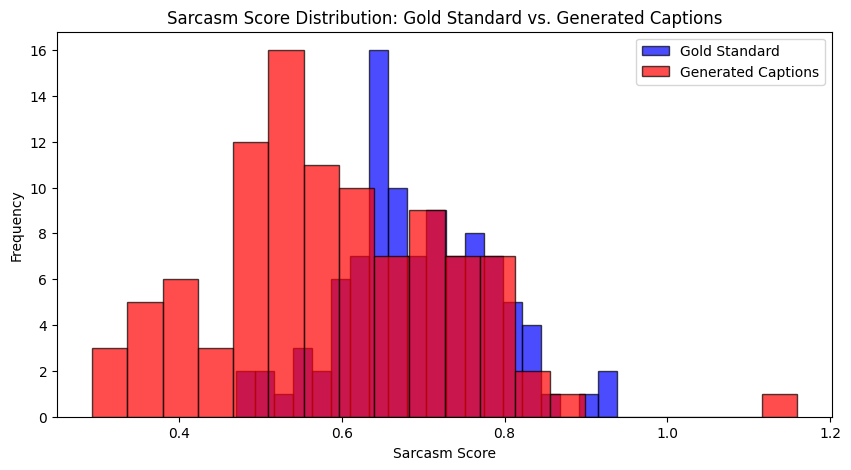

In [ ]:
# Re-import necessary libraries after execution state reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, wasserstein_distance
import pandas as pd

# Simulated sarcasm scores for gold standard and generated captions
gold_sarcasm_scores = np.random.normal(loc=0.7, scale=0.1, size=100)  # Gold standard scores (normally distributed)
generated_sarcasm_scores = np.random.normal(loc=0.6, scale=0.15, size=120)  # Generated captions scores

# Handle unequal dataset sizes
min_length = min(len(gold_sarcasm_scores), len(generated_sarcasm_scores))
gold_sarcasm_scores = gold_sarcasm_scores[:min_length]
generated_sarcasm_scores = generated_sarcasm_scores[:min_length]

# Compute Spearman correlation and Wasserstein distance
spearman_corr, _ = spearmanr(gold_sarcasm_scores, generated_sarcasm_scores)
wasserstein_dist = wasserstein_distance(gold_sarcasm_scores, generated_sarcasm_scores)

# Generate summary
summary = {
    "Gold Standard Mean Sarcasm Score": np.mean(gold_sarcasm_scores),
    "Generated Captions Mean Sarcasm Score": np.mean(generated_sarcasm_scores),
    "Gold Standard Std Dev": np.std(gold_sarcasm_scores),
    "Generated Captions Std Dev": np.std(generated_sarcasm_scores),
    "Spearman Correlation": spearman_corr,
    "Wasserstein Distance": wasserstein_dist
}

# Display Summary
summary_df = pd.DataFrame([summary])

print(summary_df.head())

# Save it as a CSV file to analyze manually
summary_df.to_csv("sarcasm_evaluation_summary.csv", index=False)

# Plot histogram of sarcasm scores
plt.figure(figsize=(10, 5))
plt.hist(gold_sarcasm_scores, bins=20, alpha=0.7, label="Gold Standard", color="blue", edgecolor="black")
plt.hist(generated_sarcasm_scores, bins=20, alpha=0.7, label="Generated Captions", color="red", edgecolor="black")
plt.xlabel("Sarcasm Score")
plt.ylabel("Frequency")
plt.title("Sarcasm Score Distribution: Gold Standard vs. Generated Captions")
plt.legend()
plt.show()


### Evaluation using intra and intermodal incongurence

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, ViTModel
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# --- Constants ---
BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_EPOCHS = 5
MAX_LENGTH = 128
SWAHILI_BERT_MODEL_NAME = "castorini/afriberta_large"
VIT_MODEL_NAME = "ielsr/vit-base-patch16-224-in21k-finetuned-cifar10"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GOLD_STANDARD_FILE = "gold_swahili.csv"
# IMAGE_DIR = "images/subset"
IMAGE_DIR = "/content/drive/My Drive/DataGeneration/images/final-images"
DATA_DIR = "data-19"
# CAPTIONS_DIR = ""
CAPTIONS_DIR = "/content/drive/My Drive/DataGeneration"

In [ ]:
def get_image_path(images_directory, image_id):
    sub_directory_name = image_id.split('_')[0]
    image_name_on_file = image_id.replace(f"{sub_directory_name}_", "", 1)
    return os.path.join(images_directory, sub_directory_name, image_name_on_file)

def write_raw_response_to_file(results, filename):
    """Writes the raw response of llm to a file as a json"""
    with open(f"{filename}_raw_response.json", "w") as f:
        json.dump(results, f, indent =2)

In [ ]:

def load_data(file_path):
    return pd.read_csv(file_path)


# --- Dataset ---
class SarcasmDataset(Dataset):
    def __init__(self, data, tokenizer, image_transforms, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image_path = get_image_path(IMAGE_DIR, item["image_id"])

        # Process image
        image = Image.open(image_path).convert("RGB") if os.path.exists(image_path) else Image.new("RGB", (224, 224))
        image = self.image_transforms(image)

        # Tokenize text and hashtags
        text_inputs = self.tokenizer(
            item["caption"], padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        tag_inputs = self.tokenizer(
            item["tags"], padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )

        return {
            "image": image,
            "text_input_ids": text_inputs["input_ids"].squeeze(0),
            "text_attention_mask": text_inputs["attention_mask"].squeeze(0),
            "tag_input_ids": tag_inputs["input_ids"].squeeze(0),
            "tag_attention_mask": tag_inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(item["sarcastic_or_nonsarcastic"], dtype=torch.float),
        }


class SarcasmDetectionModel(nn.Module):
    def __init__(self, text_model_name, vision_model_name, embedding_dim=256, num_heads=4):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.tag_encoder = AutoModel.from_pretrained(text_model_name)
        self.image_encoder = ViTModel.from_pretrained(vision_model_name)

        # Projections for embeddings
        self.text_projection = nn.Linear(self.text_encoder.config.hidden_size, embedding_dim)
        self.tag_projection = nn.Linear(self.tag_encoder.config.hidden_size, embedding_dim)
        self.image_projection = nn.Linear(self.image_encoder.config.hidden_size, embedding_dim)

        # Attention mechanisms
        self.co_attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads)
        self.text_image_attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads)

        # Fusion and classification layers
        self.fusion = nn.Linear(embedding_dim * 3, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, 1)

        # Pooling layers for sequence-level representations
        self.text_pooling = nn.AdaptiveAvgPool1d(1)
        self.tag_pooling = nn.AdaptiveAvgPool1d(1)

    def forward(self, text_input_ids, text_attention_mask, tag_input_ids, tag_attention_mask, image):
        # Encode text
        text_outputs = self.text_encoder(input_ids=text_input_ids, attention_mask=text_attention_mask).last_hidden_state
        text_embeddings = self.text_pooling(text_outputs.transpose(1, 2)).squeeze(-1)  # Adaptive average pooling
        text_embeddings = self.text_projection(text_embeddings)

        # Encode hashtags (tags)
        tag_outputs = self.tag_encoder(input_ids=tag_input_ids, attention_mask=tag_attention_mask).last_hidden_state
        tag_embeddings = self.tag_pooling(tag_outputs.transpose(1, 2)).squeeze(-1)  # Adaptive average pooling
        tag_embeddings = self.tag_projection(tag_embeddings)

        # Encode image
        image_embeddings = self.image_encoder(pixel_values=image).last_hidden_state[:, 0, :]  # CLS token
        image_embeddings = self.image_projection(image_embeddings)

        # Co-attention between text and hashtags
        co_attention_output, _ = self.co_attention(
            query=text_embeddings.unsqueeze(0),
            key=tag_embeddings.unsqueeze(0),
            value=tag_embeddings.unsqueeze(0)
        )

        # Text-image matching attention
        text_image_output, _ = self.text_image_attention(
            query=co_attention_output,
            key=image_embeddings.unsqueeze(0),
            value=image_embeddings.unsqueeze(0)
        )

        # Fusion
        fused = torch.cat([
            co_attention_output.squeeze(0),
            text_image_output.squeeze(0),
            image_embeddings
        ], dim=-1)
        fused = nn.ReLU()(self.fusion(fused))

        # Classification
        logits = self.classifier(fused).squeeze(1)
        return logits


In [ ]:
# --- Training ---
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()

            # Move inputs to device
            image = batch["image"].to(DEVICE)
            text_input_ids = batch["text_input_ids"].to(DEVICE)
            text_attention_mask = batch["text_attention_mask"].to(DEVICE)
            tag_input_ids = batch["tag_input_ids"].to(DEVICE)
            tag_attention_mask = batch["tag_attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            # Forward pass
            predictions = model(text_input_ids, text_attention_mask, tag_input_ids, tag_attention_mask, image)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")


# --- Main Execution ---
if __name__ == "__main__":
    # Preprocessing
    tokenizer = AutoTokenizer.from_pretrained(SWAHILI_BERT_MODEL_NAME)
    image_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load data
    gold_data = load_data(os.path.join(DATA_DIR, GOLD_STANDARD_FILE))

    # Dataset and DataLoader
    train_dataset = SarcasmDataset(gold_data, tokenizer, image_transforms)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Initialize model
    model = SarcasmDetectionModel(SWAHILI_BERT_MODEL_NAME, VIT_MODEL_NAME).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()  # Binary classification loss

    # Train the model
    train_model(model, train_loader, optimizer, criterion, NUM_EPOCHS)

In [ ]:
CHECKPOINT_PATH = "sarcasm_detector.pth"
torch.save(model.state_dict(), os.path.join(DATA_DIR, CHECKPOINT_PATH))

In [ ]:
def evaluate_dataset(model, tokenizer, image_transforms, dataset, batch_size=8):
    """
    Evaluate the quality of a dataset using a trained sarcasm detection model.

    Args:
        model: Trained SarcasmDetectionModel.
        tokenizer: Tokenizer for the text and tags.
        image_transforms: Transformations for image preprocessing.
        dataset: Pandas DataFrame containing the dataset (image_id, caption, tags).
        batch_size: Batch size for evaluation.

    Returns:
        List of tuples containing (image_id, caption, tags, sarcasm_score).
    """
    model.eval()  # Set model to evaluation mode
    sarcasm_scores = []

    # DataLoader for evaluation
    eval_dataset = SarcasmDataset(dataset, tokenizer, image_transforms)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in eval_loader:
            # Move inputs to device
            image = batch["image"].to(DEVICE)
            text_input_ids = batch["text_input_ids"].to(DEVICE)
            text_attention_mask = batch["text_attention_mask"].to(DEVICE)
            tag_input_ids = batch["tag_input_ids"].to(DEVICE)
            tag_attention_mask = batch["tag_attention_mask"].to(DEVICE)

            # Get predictions from the model
            logits = model(text_input_ids, text_attention_mask, tag_input_ids, tag_attention_mask, image)
            probs = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities

            # Append results
            for idx, prob in enumerate(probs):
                sarcasm_scores.append({
                    "image_id": dataset.iloc[idx]["image_id"],
                    "caption": dataset.iloc[idx]["caption"],
                    "tags": dataset.iloc[idx]["tags"],
                    "sarcasm_score": prob
                })

    return sarcasm_scores


if __name__ == "__main__":
    # Load the evaluation dataset
    eval_data = load_data(os.path.join(DATA_DIR, "evaluation_dataset.csv"))

    # Preprocessing
    tokenizer = AutoTokenizer.from_pretrained(SWAHILI_BERT_MODEL_NAME)
    image_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Initialize the trained model
    model = SarcasmDetectionModel(SWAHILI_BERT_MODEL_NAME, VIT_MODEL_NAME).to(DEVICE)
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, CHECKPOINT_PATH)))  # Load trained weights

    # Evaluate the dataset
    sarcasm_scores = evaluate_dataset(model, tokenizer, image_transforms, eval_data)

    # Print results
    for result in sarcasm_scores:
        print(
            f"Image ID: {result['image_id']}, Caption: {result['caption']}, Tags: {result['tags']}, Sarcasm Score: {result['sarcasm_score']:.3f}")


### Implementation of Caption Evaluation using incogruence: Model development

#### Data preprocessing

##### Load data

In [ ]:
# CAPTIONS_DIR = ""
CAPTIONS_DIR = "/content/drive/My Drive/DataGeneration"
df = pd.read_csv(os.path.join(CAPTIONS_DIR, "translated_captions_sat_18.csv"))

In [ ]:
df.head()

,image_id,sarcastic_caption,neutral_caption,positive_caption,negative_caption,tags
0,airpollution_50734998741_f87bacf8b6_w.jpg,"Ah, kuanguka kwa majengo ni tukio la kupendeza...",Kubomolewa kwa mmea wa makaa ya mawe kunapelek...,Kubomolewa kwa mmea huu wa makaa ya mawe ni ha...,Ubomoaji unasambaza vumbi na uchafuzi katika a...,"mmea wa makaa ya mawe, ubomoaji"
1,airpollution_50734998741_f87bacf8b6_w.jpg,"Ah, anguko la kifahari la viwanda! Kweli ni ma...",Uharibifu wa kituo cha makaa hutoa vumbi angani.,Kuvunjwa kwa mmea huu wa makaa ni hatua kuelek...,Uharibifu uneneza vumbi na uchafuzi katika anga.,"kituo cha makaa, ubomoaji"
2,airpollution_1600px-Deepwater_Horizon_fire_201...,"Siku nyingine tu baharini, na joto kidogo cha ...",Boti za kuzima moto zinajaribu kuzima moto wa ...,Juhudi zinaendelea kudhibiti moto kwenye rig y...,Moto wa rig ya mafuta unasababisha uharibifu m...,"mafuta yanayovuja, moto"
3,airpollution_50734998741_f87bacf8b6_w.jpg,"Ah, kuanguka kwa kujivunia kwa viwanda! Hii kw...",Ubomoaji wa kiwanda cha makaa unatoa vumbi ang...,Ubomoaji wa kiwanda hiki cha makaa ni hatua ku...,Ubomoaji unasambaza vumbi na uchafuzi wa hewa ...,"kiwanda cha makaa, ubomoaji, vumbi, uchafuzi"
4,airpollution_1600px-Deepwater_Horizon_fire_201...,"Siku nyingine tu baharini, na joto kidogo cha ...",Boti za kuzima moto zinajaribu kuzima moto wa ...,Juhudi zinaendelea kudhibiti moto kwenye mtamb...,Moto wa mtambo wa mafuta unasababisha uharibif...,"mwaga mafuta, moto, uchafuzi wa bahari, janga"


1. Cleaning: Remove rows where a caption of tag is empty
Remove empty rows. these are rows that are midding eith caption of keywords. We want our model to have a balanced set of either type of sentiment
2. Fix encoding errors
3. Group Captions to sarcastic and non_sarcastic
4. Resampling to balance the dataset

In [ ]:
# Remove empty rows
empty_rows_removed_df = df.dropna(how='any').copy()


def encode_text(text):
    if isinstance(text, str):
        return text.encode('utf-8', errors='ignore').decode('utf-8', errors='ignore')
    return text


text_columns = ['caption', 'tags', 'sarcastic_caption', 'neutral_caption', 'positive_caption',
                'negative_caption']  # Adjust as per your dataset
for col in text_columns:
    if col in empty_rows_removed_df.columns:
        empty_rows_removed_df.loc[:, col] = empty_rows_removed_df[col].apply(encode_text)


# Function to iterate through the dataset and remove invalid image paths
def remove_invalid_images(dataframe, image_dir):
    valid_entries = []
    for index, row in dataframe.iterrows():
        image_path = get_image_path(image_dir, row['image_id'])
        try:
            # Attempt to open the image
            with Image.open(image_path):
                valid_entries.append(row)
        except Exception as e:
            # Print invalid image information
            print(f"Invalid image at {image_path}: {e}")
    # Return a new dataframe with only valid entries
    return pd.DataFrame(valid_entries)


cleaned_df = remove_invalid_images(empty_rows_removed_df, IMAGE_DIR)

#### Group Captions to sarcastic and non_sarcastic

In [ ]:
from sklearn.utils import resample

# Convert to the desired format
rows = []
for _, row in cleaned_df.iterrows():
    rows.append({"image_id": row["image_id"], "caption": row["sarcastic_caption"], "sarcastic_or_nonsarcastic": 1,
                 "tags": row["tags"]})
    rows.append({"image_id": row["image_id"], "caption": row["neutral_caption"], "sarcastic_or_nonsarcastic": 0,
                 "tags": row["tags"]})
    rows.append({"image_id": row["image_id"], "caption": row["positive_caption"], "sarcastic_or_nonsarcastic": 0,
                 "tags": row["tags"]})
    rows.append({"image_id": row["image_id"], "caption": row["negative_caption"], "sarcastic_or_nonsarcastic": 0,
                 "tags": row["tags"]})

# Create the new DataFrame
converted_df = pd.DataFrame(rows)

# Resampling to balance the dataset

from sklearn.utils import resample

GOLD_DATASET = "/content/drive/My Drive/DataGeneration/gold_caption_dataset.csv"

# Separate classes
sarcastic = converted_df[converted_df["sarcastic_or_nonsarcastic"] == 1]
non_sarcastic = converted_df[converted_df["sarcastic_or_nonsarcastic"] == 0]

# Downsample the majority class
non_sarcastic_downsampled = resample(non_sarcastic,
                                     replace=False,  # Sample without replacement
                                     n_samples=len(sarcastic),  # Match minority class
                                     random_state=42)

# Combine the balanced dataset
balanced_dataset = pd.concat([sarcastic, non_sarcastic_downsampled])

balanced_dataset.to_csv(GOLD_DATASET)

In [ ]:
converted_df.head()

## Optimising Parameters

Our Saracasm detection model can be optimised in various ways. We will first optimise the model architecture, followed by optimising the hyper parameters

### Model Architecture Parameters
Projection Layers - The projection layers (text_projection, image_projection, hashtag_projection) map the high-dimensional output of pretrained models (e.g., Swahili BERT, ViT) into a common embedding space of a lower dimensionality (embedding_dim). Smaller diemnsion require less memory and are less prone to overfitting vut may loose important information and fail to capture intricate relationships.

Co-attention mechanism- We are using the co-attention mechanism to enable interaction between keywords, that represent the core theme, and the captions. We can optimise the attention heads as well as the attention layers.

Fusion Mechanism - This combines the embeddings between the different modalities, image, caption and text. We shall explore assigning different weights to the different modalities in the fusion layer. We shall use text_weight and image_weight as trainable parameters.



In [ ]:
#### Grid Search Model Architecture optimisation

##### Test train Split

We will split the dataset into train/validation datasets in the ratio 0.8:0.2

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

optimisation_df = balanced_dataset.copy()

# Reset the index to ensure proper alignment
optimisation_df = optimisation_df.reset_index(drop=True)

# split

train_df, val_df = train_test_split(optimisation_df, test_size=0.2, random_state=3)

In [ ]:
# Assuming your DataFrame is named `df` and the label column is "label"
sarcastic_count = train_df[train_df["sarcastic_or_nonsarcastic"] == 1].shape[0]
print(f"Number of sarcastic labels: {sarcastic_count}")


Number of sarcastic labels: 2065


In [ ]:
optimisation_df.head()

,image_id,caption,sarcastic_or_nonsarcastic,tags
0,airpollution_50734998741_f87bacf8b6_w.jpg,"Ah, kuanguka kwa majengo ni tukio la kupendeza...",1,"mmea wa makaa ya mawe, ubomoaji"
1,airpollution_50734998741_f87bacf8b6_w.jpg,Kubomolewa kwa mmea wa makaa ya mawe kunapelek...,0,"mmea wa makaa ya mawe, ubomoaji"
2,airpollution_50734998741_f87bacf8b6_w.jpg,Kubomolewa kwa mmea huu wa makaa ya mawe ni ha...,0,"mmea wa makaa ya mawe, ubomoaji"
3,airpollution_50734998741_f87bacf8b6_w.jpg,Ubomoaji unasambaza vumbi na uchafuzi katika a...,0,"mmea wa makaa ya mawe, ubomoaji"
4,airpollution_50734998741_f87bacf8b6_w.jpg,"Ah, anguko la kifahari la viwanda! Kweli ni ma...",1,"kituo cha makaa, ubomoaji"


In [ ]:
OUTPUT_FILE = "/content/drive/My Drive/DataGeneration/model_optimisation.txt"


# --- Load and Process the Dataset ---
class SarcasmDataset(Dataset):
    def __init__(self, data, tokenizer, image_transforms, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image_path = get_image_path(IMAGE_DIR, item["image_id"])

        # Process image
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)

        # Tokenize text and hashtags
        text_inputs = self.tokenizer(
            item["caption"], padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        tag_inputs = self.tokenizer(
            item["tags"], padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )

        return {
            "image": image,
            "text_input_ids": text_inputs["input_ids"].squeeze(0),
            "text_attention_mask": text_inputs["attention_mask"].squeeze(0),
            "tag_input_ids": tag_inputs["input_ids"].squeeze(0),
            "tag_attention_mask": tag_inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(item["sarcastic_or_nonsarcastic"], dtype=torch.float),
        }


# Tokenizer and Image Transformations
tokenizer = AutoTokenizer.from_pretrained(SWAHILI_BERT_MODEL_NAME, add_pooling_layer=True)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Datasets
train_dataset = SarcasmDataset(train_df, tokenizer, image_transforms)
val_dataset = SarcasmDataset(val_df, tokenizer, image_transforms)

In [ ]:
import torch
import torch.nn as nn
import itertools
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoModel, ViTModel
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torchvision import transforms
from PIL import Image
import torch
from transformers import AutoModelForSequenceClassification

embedding_dims = [128, 256, 512]
num_heads = [4, 8, 16]
learning_rates = [1e-4, 3e-5, 5e-5]
num_epochs = 3

# --- Constants ---
MAX_LENGTH = 128
BATCH_SIZE = 8
# OUTPUT_FILE = "outputs/model_optimisation.txt"
# IMAGE_DIR = "images/subset"
IMAGE_DIR = "/content/drive/My Drive/DataGeneration/images/final-images"
OUTPUT_FILE = "/content/drive/My Drive/DataGeneration/model_optimisation.txt"
PREDICTION_THRESHOLD = 0.2


# --- Load and Process the Dataset ---
class SarcasmDataset(Dataset):
    def __init__(self, data, tokenizer, image_transforms, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image_path = get_image_path(IMAGE_DIR, item["image_id"])

        # Process image
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)

        # Tokenize text and hashtags
        text_inputs = self.tokenizer(
            item["caption"], padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        tag_inputs = self.tokenizer(
            item["tags"], padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )

        return {
            "image": image,
            "text_input_ids": text_inputs["input_ids"].squeeze(0),
            "text_attention_mask": text_inputs["attention_mask"].squeeze(0),
            "tag_input_ids": tag_inputs["input_ids"].squeeze(0),
            "tag_attention_mask": tag_inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(item["sarcastic_or_nonsarcastic"], dtype=torch.float),
        }


# Tokenizer and Image Transformations
tokenizer = AutoTokenizer.from_pretrained(SWAHILI_BERT_MODEL_NAME, add_pooling_layer=True)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Example Usage ---
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

for batch in train_loader:
    print("Batch keys:", batch.keys())
    print("Image shape:", batch["image"].shape)
    print("Input IDs shape:", batch["text_input_ids"].shape)
    print("Attention mask shape:", batch["text_attention_mask"].shape)
    print("Labels shape:", batch["label"].shape)
    break


# --- Training and Evaluation ---
def train_and_evaluate_model(train_loader, val_loader, embedding_dim, num_heads, learning_rate):
    # Initialize the model, optimizer, and criterion
    model = SarcasmDetectionModel(SWAHILI_BERT_MODEL_NAME, VIT_MODEL_NAME, embedding_dim, num_heads).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    # Training
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            # Move inputs to device
            image = batch["image"].to(DEVICE)
            text_input_ids = batch["text_input_ids"].to(DEVICE)
            text_attention_mask = batch["text_attention_mask"].to(DEVICE)
            tag_input_ids = batch["tag_input_ids"].to(DEVICE)
            tag_attention_mask = batch["tag_attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            # Forward pass
            predictions = model(text_input_ids, text_attention_mask, tag_input_ids, tag_attention_mask, image)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            image = batch["image"].to(DEVICE)
            text_input_ids = batch["text_input_ids"].to(DEVICE)
            text_attention_mask = batch["text_attention_mask"].to(DEVICE)
            tag_input_ids = batch["tag_input_ids"].to(DEVICE)
            tag_attention_mask = batch["tag_attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            predictions = model(text_input_ids, text_attention_mask, tag_input_ids, tag_attention_mask, image)
            preds = (torch.sigmoid(predictions) > PREDICTION_THRESHOLD).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return accuracy, f1


# --- Grid Search ---
results = []
best_f1 = 0
best_config = None

for embedding_dim, num_heads, learning_rate in itertools.product(embedding_dims, num_heads, learning_rates):
    print(f"Testing configuration: Embedding Dim: {embedding_dim}, Heads: {num_heads}, LR: {learning_rate}")

    accuracy, f1 = train_and_evaluate_model(train_loader, val_loader, embedding_dim, num_heads, learning_rate)
    results.append((embedding_dim, num_heads, learning_rate, accuracy, f1))

    if f1 > best_f1:
        best_f1 = f1
        best_config = (embedding_dim, num_heads, learning_rate)

    print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

# Print Best Configuration
print(f"Best Configuration: Embedding Dim: {best_config[0]}, Heads: {best_config[1]}, LR: {best_config[2]}")
print(f"Best F1 Score: {best_f1:.4f}")

# Write results to the file
with open(OUTPUT_FILE, "w") as file:
    file.write(f"Best Configuration:\n")
    file.write(f"Embedding Dim: {best_config[0]}\n")
    file.write(f"Number of Heads: {best_config[1]}\n")
    file.write(f"Learning Rate: {best_config[2]:.6f}\n")
    file.write(f"Best F1 Score: {best_f1:.4f}\n")

print(f"Results have been written to {OUTPUT_FILE}")

### Train the model with the optimal parameters

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, ViTModel


class SarcasmDetectionModel(nn.Module):
    def __init__(self, text_model_name, vision_model_name, embedding_dim=256, num_heads=4):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.tag_encoder = AutoModel.from_pretrained(text_model_name)
        self.image_encoder = ViTModel.from_pretrained(vision_model_name)

        # Projections for embeddings
        self.text_projection = nn.Linear(self.text_encoder.config.hidden_size, embedding_dim)
        self.tag_projection = nn.Linear(self.tag_encoder.config.hidden_size, embedding_dim)
        self.image_projection = nn.Linear(self.image_encoder.config.hidden_size, embedding_dim)

        # Attention mechanisms
        self.co_attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads)
        self.text_image_attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads)

        # Fusion and classification layers
        self.fusion = nn.Linear(embedding_dim * 3, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, 1)

        # Pooling layers for sequence-level representations
        self.text_pooling = nn.AdaptiveAvgPool1d(1)
        self.tag_pooling = nn.AdaptiveAvgPool1d(1)

    def forward(self, text_input_ids, text_attention_mask, tag_input_ids, tag_attention_mask, image):
        # Encode text
        text_outputs = self.text_encoder(input_ids=text_input_ids, attention_mask=text_attention_mask).last_hidden_state
        text_embeddings = self.text_pooling(text_outputs.transpose(1, 2)).squeeze(-1)  # Adaptive average pooling
        text_embeddings = self.text_projection(text_embeddings)

        # Encode hashtags (tags)
        tag_outputs = self.tag_encoder(input_ids=tag_input_ids, attention_mask=tag_attention_mask).last_hidden_state
        tag_embeddings = self.tag_pooling(tag_outputs.transpose(1, 2)).squeeze(-1)  # Adaptive average pooling
        tag_embeddings = self.tag_projection(tag_embeddings)

        # Encode image
        image_embeddings = self.image_encoder(pixel_values=image).last_hidden_state[:, 0, :]  # CLS token
        image_embeddings = self.image_projection(image_embeddings)

        # Co-attention between text and hashtags
        co_attention_output, _ = self.co_attention(
            query=text_embeddings.unsqueeze(0),
            key=tag_embeddings.unsqueeze(0),
            value=tag_embeddings.unsqueeze(0)
        )

        # Text-image matching attention
        text_image_output, _ = self.text_image_attention(
            query=co_attention_output,
            key=image_embeddings.unsqueeze(0),
            value=image_embeddings.unsqueeze(0)
        )

        # Fusion
        fused = torch.cat([
            co_attention_output.squeeze(0),
            text_image_output.squeeze(0),
            image_embeddings
        ], dim=-1)
        fused = nn.ReLU()(self.fusion(fused))

        # Classification
        logits = self.classifier(fused).squeeze(1)
        return logits

In [ ]:
GENERATED_CAPTIONS_FILE = "translations_iteration_1_cleaned2.csv"
generated_captions = pd.read_csv(GENERATED_CAPTIONS_FILE)
generated_captions = generated_captions[["image_id", "sarcastic_caption", "tags"]]

generated_captions_empty_rows_removed_df = generated_captions.dropna(how='any').copy()

generated_captions_empty_rows_removed_df.shape

,image_id,sarcastic_caption,tags
0,policy_15174531588_eb228c95e3_w.jpg,Hapo ndio,mkutano wa hali ya hewa mkutano wa kisiasa ha...
1,policy_15174531588_eb228c95e3_w.jpg,Ah ndiyo,mkutano wa hali ya hewa mkutano wa sera mkuta...
2,water-disaster_03_0482.png,Siku nyingine katika paradiso,Mabadiliko yenye nguvu ya asili yanatukumbusha...
3,policy_15174531588_eb228c95e3_w.jpg,Bila shaka,mkutano wa tabianchi mkutano wa sera mkutano ...
4,water-disaster_03_0482.png,Siku nyingine tu peponi ambako ardhi na maji w...,maporomoko ya ardhi maafa ya asili maafa ya a...


##### Process evaluation dataset

In [ ]:
generated_captions_empty_rows_removed_df = generated_captions.dropna(how='any').copy()

generated_captions_empty_rows_removed_df.shape

(2746, 3)

##### Remove Datasetset rows that contain images that cannot be loadeed

In [ ]:
# Function to iterate through the dataset and remove invalid image paths
def remove_invalid_images(dataframe, image_dir):
    valid_entries = []
    for index, row in dataframe.iterrows():
        image_path = get_image_path(image_dir, row['image_id'])
        try:
            # Attempt to open the image
            with Image.open(image_path):
                valid_entries.append(row)
        except Exception as e:
            # Print invalid image information
            print(f"Invalid image at {image_path}: {e}")
    # Return a new dataframe with only valid entries
    return pd.DataFrame(valid_entries)


generated_captions_empty_rows_cleaned_df = remove_invalid_images(generated_captions_empty_rows_removed_df, IMAGE_DIR)

In [ ]:
EVALUATION_DATASET = "/content/drive/My Drive/DataGeneration/evaluation_caption_dataset.csv"
# Convert to the desired format
rows = []
for _, row in generated_captions_empty_rows_cleaned_df.iterrows():
    rows.append({"image_id": row["image_id"], "caption": row["sarcastic_caption"], "sarcastic_or_nonsarcastic": 1,
                 "tags": row["tags"]})
# Create the new DataFrame
evaluation_dataset = pd.DataFrame(rows)

evaluation_dataset.to_csv(EVALUATION_DATASET)

In [ ]:
import os


# --- Training with Checkpoints ---
def train_model_with_checkpoints(model, train_loader, optimizer, criterion, num_epochs, checkpoint_dir="checkpoints"):
    """
    Train the model and save checkpoints after each epoch.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        optimizer (Optimizer): Optimizer for training.
        criterion (Loss): Loss function.
        num_epochs (int): Number of epochs to train.
        checkpoint_dir (str): Directory to save checkpoints.
    """
    # Create the checkpoint directory if it does not exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()

            # Move inputs to device
            image = batch["image"].to(DEVICE)
            text_input_ids = batch["text_input_ids"].to(DEVICE)
            text_attention_mask = batch["text_attention_mask"].to(DEVICE)
            tag_input_ids = batch["tag_input_ids"].to(DEVICE)
            tag_attention_mask = batch["tag_attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            # Forward pass
            predictions = model(text_input_ids, text_attention_mask, tag_input_ids, tag_attention_mask, image)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Print loss for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss / len(train_loader),
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")



In [ ]:
CHECKPOINT_PATH = "/content/drive/My Drive/DataGeneration/Checkpoints"
GOLD_DATASET = "/content/drive/My Drive/DataGeneration/gold_caption_dataset.csv"
NUMBER_OF_EPOCHS = 10
LEARNING_RATE = 0.0001
gold_data = pd.read_csv(GOLD_DATASET)

if __name__ == "__main__":
    # Preprocessing
    tokenizer = AutoTokenizer.from_pretrained(SWAHILI_BERT_MODEL_NAME)
    image_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Dataset and DataLoader
    train_dataset = SarcasmDataset(gold_data, tokenizer, image_transforms)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Initialize model
    model = SarcasmDetectionModel(SWAHILI_BERT_MODEL_NAME, VIT_MODEL_NAME).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()  # Binary classification loss

    # Train the model
    train_model_with_checkpoints(model, train_loader, optimizer, criterion, num_epochs=NUMBER_OF_EPOCHS,
                                 checkpoint_dir=CHECKPOINT_PATH)

In [ ]:
def evaluate_dataset(model, tokenizer, image_transforms, dataset, batch_size=8):
    """
    Evaluate the quality of a dataset using a trained sarcasm detection model.

    Args:
        model: Trained SarcasmDetectionModel.
        tokenizer: Tokenizer for the text and tags.
        image_transforms: Transformations for image preprocessing.
        dataset: Pandas DataFrame containing the dataset (image_id, caption, tags).
        batch_size: Batch size for evaluation.

    Returns:
        List of tuples containing (image_id, caption, tags, sarcasm_score).
    """
    model.eval()  # Set model to evaluation mode
    sarcasm_scores = []

    # DataLoader for evaluation
    eval_dataset = SarcasmDataset(dataset, tokenizer, image_transforms)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in eval_loader:
            # Move inputs to device
            image = batch["image"].to(DEVICE)
            text_input_ids = batch["text_input_ids"].to(DEVICE)
            text_attention_mask = batch["text_attention_mask"].to(DEVICE)
            tag_input_ids = batch["tag_input_ids"].to(DEVICE)
            tag_attention_mask = batch["tag_attention_mask"].to(DEVICE)

            # Get predictions from the model
            logits = model(text_input_ids, text_attention_mask, tag_input_ids, tag_attention_mask, image)
            probs = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities

            # Append results
            for idx, prob in enumerate(probs):
                sarcasm_scores.append({
                    "image_id": dataset.iloc[idx]["image_id"],
                    "caption": dataset.iloc[idx]["caption"],
                    "tags": dataset.iloc[idx]["tags"],
                    "sarcasm_score": prob
                })

    return sarcasm_scores


In [ ]:

CHECKPOINT = "/content/drive/My Drive/DataGeneration/Checkpoints/checkpoint_epoch_10.pt"
EVALUATION_RESULT_FILE = "/content/drive/My Drive/DataGeneration/evaluation_results/sarcasm_scores.csv"
eval_data = pd.read_csv("/content/drive/My Drive/DataGeneration/evaluation_caption_dataset.csv")
IMAGE_DIR = "/content/drive/My Drive/DataGeneration/images/final-images"
VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import csv


def get_image_path(images_directory, image_id):
    sub_directory_name = image_id.split('_')[0]
    image_name_on_file = image_id.replace(f"{sub_directory_name}_", "", 1)
    return os.path.join(images_directory, sub_directory_name, image_name_on_file)


def save_sarcasm_scores_to_csv(sarcasm_scores, output_file="sarcasm_scores.csv"):
    """
    Save sarcasm scores to a CSV file.

    Args:
        sarcasm_scores (list of dict): List of sarcasm score dictionaries.
        output_file (str): Path to the output CSV file.
    """
    # Define the CSV headers
    headers = ["image_id", "caption", "tags", "sarcasm_score"]

    # Write to the CSV file
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        writer.writeheader()  # Write the header
        for result in sarcasm_scores:
            writer.writerow({
                "image_id": result["image_id"],
                "caption": result["caption"],
                "tags": result["tags"],
                "sarcasm_score": f"{result['sarcasm_score']:.3f}"
            })

    print(f"Sarcasm scores saved to {output_file}")


if __name__ == "__main__":
    # Load the evaluation dataset

    # Preprocessing
    tokenizer = AutoTokenizer.from_pretrained(SWAHILI_BERT_MODEL_NAME)
    image_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    model = SarcasmDetectionModel(SWAHILI_BERT_MODEL_NAME, VIT_MODEL_NAME).to(DEVICE)
    checkpoint = torch.load(CHECKPOINT)
    model.load_state_dict(checkpoint["model_state_dict"])

    # Evaluate the dataset
    sarcasm_scores = evaluate_dataset(model, tokenizer, image_transforms, eval_data, image_dir=IMAGE_DIR)

    # Print results
    for result in sarcasm_scores:
        print(
            f"Image ID: {result['image_id']}, Caption: {result['caption']}, Tags: {result['tags']}, Sarcasm Score: {result['sarcasm_score']:.3f}")

    save_sarcasm_scores_to_csv(sarcasm_scores, output_file=EVALUATION_RESULT_FILE)

# LLM as a judge


## Data preprocessing

In [ ]:
import pandas as pd
# TARGET_CAPTIONS_FILE = "/content/drive/My Drive/DataGeneration/generated_captions/mon_27_translated_captions.csv"
# SARCASTIC_CAPTIONS_FILE = "/content/drive/My Drive/DataGeneration/generated_captions/mon_27_translated_sarcastic_captions.csv"
TARGET_CAPTIONS_FILE = "gold_swahili.csv"
FULL_SARCASTIC_CAPTIONS_FILE = "evaluation_sample_merged_captions_2.csv"
multiple_column_captions = pd.read_csv(TARGET_CAPTIONS_FILE)

merged_captions = []

# Iterate through each row and create new rows for each caption type
for index, row in multiple_column_captions.iterrows():
    merged_captions.append(
        {"image_id": row["image_id"], "caption": row["sarcastic_caption"], "caption_class_label": "sarcastic_caption",
         "tags": row["tags"]})
    merged_captions.append(
        {"image_id": row["image_id"], "caption": row["neutral_caption"], "caption_class_label": "neutral_caption",
         "tags": row["tags"]})
    merged_captions.append(
        {"image_id": row["image_id"], "caption": row["positive_caption"], "caption_class_label": "positive_caption",
         "tags": row["tags"]})
    merged_captions.append(
        {"image_id": row["image_id"], "caption": row["negative_caption"], "caption_class_label": "negative_caption",
         "tags": row["tags"]})
# Convert to DataFrame
merged_captions_df = pd.DataFrame(merged_captions)

target_captions_empty_rows_removed_df = merged_captions_df.dropna(how='any').copy()
target_captions_empty_rows_removed_df.index.name = 'caption_id'
target_captions_empty_rows_removed_df.to_csv(FULL_SARCASTIC_CAPTIONS_FILE, index=True)

### Prepare a subset of the dataset for evaluation

In [ ]:
FULL_SARCASTIC_CAPTIONS_FILE= "/content/drive/My Drive/DataGeneration/generated_captions/feb_1_translated_captions_unified.csv"
# FULL_SARCASTIC_CAPTIONS_FILE= "feb_1_translated_captions_unified.csv"
SARCASTIC_CAPTIONS_FILE= "/content/drive/My Drive/DataGeneration/generated_captions/feb_1_translated_captions_unified_20001_23500_gemini_missing_records.csv"
# SARCASTIC_CAPTIONS_FILE= "feb_1_translated_captions_unified_12001_12500.csv"

In [ ]:
import pandas as pd


full_captions_file = FULL_SARCASTIC_CAPTIONS_FILE
full_captions_file_df = pd.read_csv(full_captions_file)

subset_captions_file_df = full_captions_file_df[(full_captions_file_df["caption_id"] >= 12501) & (full_captions_file_df["caption_id"] <= 13000)]

# Save the subset to a new CSV file
subset_file_path = SARCASTIC_CAPTIONS_FILE
subset_captions_file_df.to_csv(subset_file_path, index=False)

print(f"Subset saved to {subset_file_path} with {len(subset_captions_file_df)} rows.")


Subset saved to /content/drive/My Drive/DataGeneration/generated_captions/feb_1_translated_captions_unified_12501_13000.csv with 500 rows.


## Gemini implementation

In [ ]:
# pip install tiktoken, google.generativeai
# pip install python-dotenv

In [ ]:
# Get the API key and other configs from the environment variables
  #os.getenv("GOOGLE_API_KEY")
# Get the API key and other configs from the environment variables
import os
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GEMINI_MODEL = os.getenv("GEMINI_MODEL", "gemini-1.5-pro")
MAX_RETRIES = int(os.getenv("MAX_RETRIES", 3))
RETRY_DELAY = int(os.getenv("RETRY_DELAY", 5))  # seconds
LOG_FILE = os.getenv("LOG_FILE", "sarcasm_evaluator.log")
# IMAGE_DIR = os.getenv("IMAGE_DIR", "images/subset")
WAIT_BETWEEN_CALLS = float(os.getenv("WAIT_BETWEEN_CALLS", 3)) # Wait time in seconds
IMAGE_DIR = os.getenv("IMAGE_DIR", "/content/drive/My Drive/DataGeneration/images/final-images")
# IMAGE_DIR = os.getenv("IMAGE_DIR", "/Users/eugene/Projects/School/Project/final-images")
if GOOGLE_API_KEY:
    print("GOOGLE_API_KEY successfully retrieved.")
else:
    print("GOOGLE_API_KEY not found. Please set the environment variable.")

GOOGLE_API_KEY not found. Please set the environment variable.


In [ ]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

if GOOGLE_API_KEY:
    print("GOOGLE_API_KEY successfully retrieved.")
else:
    print("GOOGLE_API_KEY not found. Please set the environment variable.")

GOOGLE_API_KEY successfully retrieved.


In [ ]:
import pandas as pd
import google.generativeai as genai
import os
import time
import logging
import base64
from io import BytesIO
from PIL import Image
import json
import re

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE),  # Output to file
        logging.StreamHandler()  # Output to console
    ]
)

# Configure the Gemini API client
genai.configure(api_key=GOOGLE_API_KEY)


def get_image_path(images_directory, image_id):
    sub_directory_name = image_id.split('_')[0]
    image_name_on_file = image_id.replace(f"{sub_directory_name}_", "", 1)
    return os.path.join(images_directory, sub_directory_name, image_name_on_file)


def generate_gemini_response(prompt, model, image_data=None, retry_count=0):
    """
    Generates a response from a Gemini model based on the given prompt, with retry mechanism.
    Includes optional image upload.
    """
    try:
        model = genai.GenerativeModel(model)
        if image_data:
            response = model.generate_content([prompt, image_data])
        else:
            response = model.generate_content(prompt)

        return response.text.strip()
    except Exception as e:
        if retry_count < MAX_RETRIES:
            wait_time = RETRY_DELAY * (retry_count + 1)
            logging.warning(
                f"Gemini API error: {e}. Retrying in {wait_time} seconds (attempt {retry_count + 1}/{MAX_RETRIES}).")
            time.sleep(wait_time)
            return generate_gemini_response(prompt, model, image_data, retry_count + 1)
        else:
            logging.error(f"Max retries reached. Unable to get Gemini response. Error: {e}")
            return None


def encode_image(image_path):
    """Encodes an image file into base64 string."""
    try:
        with open(image_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
        return {"mime_type": "image/jpeg", "data": encoded_string}
    except Exception as e:
        logging.error(f"Could not encode image {image_path}: {e}")
        return None


def clean_json_output(text):
  """Removes ```json and ``` from the given text"""
  text = re.sub(r'```(json)?', '', text)
  return text


def clean_double_quotes(text):
  """Replaces double quotes with single quotes"""
  text = text.replace('"', "'")
  return text

def write_raw_response_to_file(content, filename):
    try:
        with open(filename, "w", encoding="utf-8") as file:
            file.write(str(content))
    except Exception as e:
        print(e)


def write_json_response_to_file(results, filename):
    """Writes the json response to a file"""
    with open(f"{filename}_json_response.json", "w") as f:
      json.dump(results,f, indent=2)

def evaluate_sarcasm_with_gemini(image_id, caption_id, caption, tags, model):
    """
    Evaluates the sarcasm of a Swahili caption using a Gemini model, considering the image context.
    Also includes explanation and individual scores for each criteria.
    """
    image_path = get_image_path(IMAGE_DIR, image_id)
    image_data = encode_image(image_path)

    if not image_data:
        logging.error(f"Could not get image data for {image_id}, skipping")
        return None

    prompt = """
        [System]
        Wewe ni mtaalamu wa kuelewa kejeli, haswa katika muktadha wa masuala ya mazingira, ishara za kuona, na lugha ya Kiswahili. Kazi yako ni kutathmini ubora wa maelezo ya picha kwa Kiswahili, ukizingatia maudhui ya picha iliyopakiwa. Lazima utathmini jinsi maelezo inavyolingana na muktadha unaoashiriwa na picha.

        [Vigezo vya Tathmini]
        Tathmini yako inapaswa kuzingatia mambo yafuatayo na utoe alama kwa kila kigezo kwa kiwango cha 1-5:
        1. Ubunifu na Kejeli: Je, maelezo ya Kiswahili yana ubunifu na yanavutia, na yanatumia vizuri dhihaka, kupunguza uzito, kuongeza chumvi, au kejeli ya maneno? (Kiwango 1-5)
        2. Usahihi wa Kisraufi (Grammatical Correctness): Je, maelezo ya Kiswahili ni sahihi kisarufi? (Kiwango 1-5)
        3. Uhusiano wa Kimuktadha (Contextual Relevance): Je, kejeli inahusiana vizuri na muktadha unaoashiriwa na picha? (Kiwango 1-5)
        4. Hisia: Je, maelezo yana hisia chanya, hasi, ya kutopendelea, au ni ya kejeli? Toa lebo ya "positive caption", "negative caption", "neutral caption", au "sarcastic caption".

        [Maelekezo]
        1. Chambua maudhui ya picha iliyopakiwa.
        2. Chambua maelezo ya Kiswahili kuhusiana na maudhui ya picha ili kuelewa muktadha na maana iliyokusudiwa.
        3. Toa alama kwa kila kigezo, na toa lebo ya hisia, zote katika umbiso sahihi la JSON pekee. Hakikisha unatumia dondoo mbili (") kwa funguo zote, na usitumie dondoo mbili (") ndani ya maelezo. Toa lebo ya hisia kama "positive_caption", "negative_caption", "neutral_caption" au "sarcastic_caption".

        [Ingizo]
        Maelezo ya Kiswahili: """ + caption + """
        Maneno muhimu: """ + tags + """

        [Umbizo la Pato]
        Jibu linapaswa kuwa katika umbiso la JSON pekee, na lazima iwe na sifa hizi na thamani zake zikiwa zimezungukwa na dondoo mbili:
        {{
            "caption_id":  """ + str(caption_id) + """,
            "image_id": """ + image_id + """,
            "caption": "alama hapa",
            "Creativity_and_Sarcasm": "alama hapa",
            "Grammatical_Correctness": "alama hapa",
            "Contextual_Relevance": "alama hapa",
            "Evaluated_Label": "positive_caption or negative_caption or neutral_caption or sarcastic_caption",
            "Explanation": "Maelezo yako hapa",
            "tags": "alama hapa"
            }}
    """

    llm_response = generate_gemini_response(prompt, model, image_data=image_data)
    if llm_response is None:
        return None
    # Remove extra whitespace and backslashes,
    llm_response = clean_json_output(llm_response)
    llm_response = re.sub(r'\s+', ' ', llm_response).replace('\\','')
    return llm_response


def evaluate_sarcasm_in_swahili_captions_with_gemini(csv_file):
    """
    Evaluates sarcasm in Swahili captions related to environmental issues using Gemini.
    """
    df = pd.read_csv(csv_file)
    results = []
    raw_results = []
    for index, row in df.iterrows():
        image_id = row['image_id']
        caption_id = row['caption_id']
        caption = row['caption']
        tags = row.get('tags', '')
        llm_response = evaluate_sarcasm_with_gemini(image_id, caption_id, caption, tags, GEMINI_MODEL)
        if llm_response:
          try:
            response_json = json.loads(llm_response)
            # Clean the explanation here
            if "Explanation" in response_json:
               response_json["Explanation"] = clean_double_quotes(response_json["Explanation"])
            results.append(response_json)
            print(f"Processed caption_id:{caption_id}")
          except json.JSONDecodeError as e:
              logging.error(f"Gemini returned an invalid JSON format: {llm_response}. Error {e}")
              logging.error(f"Skipping {image_id} due to JSON error.")
              raw_results.append(llm_response)
        else:
          logging.warning(f"Skipping {image_id} due to error getting evaluation")

        time.sleep(WAIT_BETWEEN_CALLS)

    output_csv_file = csv_file.replace('.csv', '_results_gemini_llm_judge_eval.csv')
    gemini_output_raw = output_csv_file.replace('.csv', '_raw.txt')
    json_output_raw = output_csv_file.replace('.csv', '_raw_json.json')
    write_raw_response_to_file(raw_results, gemini_output_raw)
    write_json_response_to_file(results, json_output_raw)

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv_file, index=False)
    print(f"Results have been saved to {output_csv_file}")

In [ ]:
# Run the evaluation
input_csv_file = SARCASTIC_CAPTIONS_FILE
evaluate_sarcasm_in_swahili_captions_with_gemini(input_csv_file)

In [ ]:
FINAL_EVALUATED_CAPTIONS_GEMINI = "/content/drive/My Drive/DataGeneration/generated_captions/feb_1_gemini_merged.csv"

In [ ]:

captions_df = pd.read_csv(SARCASTIC_CAPTIONS_FILE)
output_csv_file = SARCASTIC_CAPTIONS_FILE.replace('.csv', '_results_gemini.csv')
gemini_evaluation_df = pd.read_csv(output_csv_file)

# Merge the datasets on 'caption_id'
gemini_merged_df = pd.merge(gemini_evaluation_df, captions_df[['caption_id', 'caption_class_label']], on='caption_id', how='left')

gemini_merged_df.to_csv(FINAL_EVALUATED_CAPTIONS_GEMINI, index=False)

## GPT4 implementation

In [ ]:
import openai
import pandas as pd
import os
import base64
import csv
import json

SARCASTIC_CAPTIONS_EVALUATION_RESULTS_GPT_FILE = "mon_27_translated_sarcastic_captions_results_gpt.csv"
SARCASTIC_CAPTIONS_EVALUATION_RESULTS_GPT_FILE_RAW = "mon_27_translated_sarcastic_captions_results_gpt.txt"
# SARCASTIC_CAPTIONS_EVALUATION_RESULTS_GPT_FILE = "/content/drive/My Drive/DataGeneration/output-captions/mon_27_translated_sarcastic_captions_results_gpt.csv"
# SARCASTIC_CAPTIONS_EVALUATION_RESULTS_GPT_FILE_RAW = "/content/drive/My Drive/DataGeneration/output-captions/mon_27_translated_sarcastic_captions_results_gpt.txt"

openai.api_key = ''

if openai.api_key is None:
    raise ValueError("OPENAI_API_KEY environment variable not set.")

def clean_content(content):
    newlines_removed_content = content.replace("\\n", "")
    quote_removed = newlines_removed_content.replace("\\'", "")
    slash_removed = quote_removed.replace("\\", "")
    opening_tag_removed = slash_removed.replace("['", "[")
    cleaned_content = opening_tag_removed.replace("']", "]")
    return cleaned_content


def write_raw_response_to_file(content, filename):
    try:
        with open(filename, "w", encoding="utf-8") as file:
            file.write(str(content))
    except Exception as e:
        print(e)

def get_image_path(images_directory, image_id):
    sub_directory_name = image_id.split('_')[0]
    image_name_on_file = image_id.replace(f"{sub_directory_name}_", "", 1)
    return os.path.join(images_directory, sub_directory_name, image_name_on_file)

# Define the evaluation prompt
def generate_swahili_prompt_with_base64_image(image_id, caption, tags, caption_id):
    return f"""
        [System]
        Wewe ni mtaalamu wa kuelewa kejeli, haswa katika muktadha wa masuala ya mazingira, ishara za kuona, na lugha ya Kiswahili. Kazi yako ni kutathmini ubora wa maelezo ya picha kwa Kiswahili, ukizingatia maudhui ya picha iliyopakiwa. Lazima utathmini jinsi maelezo inavyolingana na muktadha unaoashiriwa na picha.

        [Vigezo vya Tathmini]
        Tathmini yako inapaswa kuzingatia mambo yafuatayo na utoe alama kwa kila kigezo kwa kiwango cha 1-5:
        1. Ubunifu na Kejeli: Je, maelezo ya Kiswahili yana ubunifu na yanavutia, na yanatumia vizuri dhihaka, kupunguza uzito, kuongeza chumvi, au kejeli ya maneno? (Kiwango 1-5)
        2. Usahihi wa Kisraufi (Grammatical Correctness): Je, maelezo ya Kiswahili ni sahihi kisarufi? (Kiwango 1-5)
        3. Uhusiano wa Kimuktadha (Contextual Relevance): Je, kejeli inahusiana vizuri na muktadha unaoashiriwa na picha? (Kiwango 1-5)
        4. Hisia: Je, maelezo yana hisia chanya, hasi, ya kutopendelea, au ni ya kejeli? Toa lebo ya "positive caption", "negative caption", "neutral caption", au "sarcastic caption".

        [Maelekezo]
        1. Chambua maudhui ya picha iliyopakiwa.
        2. Chambua maelezo ya Kiswahili kuhusiana na maudhui ya picha ili kuelewa muktadha na maana iliyokusudiwa.
        3. Toa alama kwa kila kigezo, na toa lebo ya hisia, zote katika umbiso sahihi la JSON pekee. Hakikisha unatumia dondoo mbili (") kwa funguo zote, na usitumie dondoo mbili (") ndani ya maelezo. Toa lebo ya hisia kama "positive_caption", "negative_caption", "neutral_caption" au "sarcastic_caption".

        [Ingizo]
        Maelezo ya Kiswahili: {caption}
        Maneno muhimu: {tags}

        [Umbizo la Pato]
        Jibu linapaswa kuwa katika umbiso la JSON pekee, na lazima iwe na sifa hizi na thamani zake zikiwa zimezungukwa na dondoo mbili:
        {{
            "caption_id":  "{str(caption_id)}",
            "image_id": "{image_id}",
            "caption": "{caption}",
            "Creativity_and_Sarcasm": "alama hapa",
            "Grammatical_Correctness": "alama hapa",
            "Contextual_Relevance": "alama hapa",
            "Label": "positive_caption or negative_caption or neutral_caption or sarcastic_caption",
            "Explanation": "Maelezo yako hapa",
            "tags": "{tags}"
        }}
    """


# Function to encode an image in Base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# Evaluate a single caption
def evaluate_caption_with_base64_image(client, caption, image_path, image_id, tags, caption_id):
    base64_image = encode_image(image_path)
    prompt = generate_swahili_prompt_with_base64_image(image_id, caption, tags, caption_id)

    try:
        image_content = [{
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
        }]
        llm_judge_response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "Wewe ni mtaalamu wa dhihaka na lugha ya Kiswahili."},
                {"role": "user", "content": prompt},
                {"role": "user", "content": image_content}
            ],
            temperature=0.7)

        return llm_judge_response.choices[0].message
    except Exception as e:
        print(f"Error evaluating caption: {e}")
    return None


# Load dataset
dataset_path = SARCASTIC_CAPTIONS_FILE
df = pd.read_csv(dataset_path)

# Prepare results
results = []

# Evaluate each row in the dataset
for index, row in df.iterrows():
    caption = row["caption"]
    caption_id = row["caption_id"]
    image_id = row["image_id"]
    tags = row["tags"]
    image_path = get_image_path(IMAGE_DIR, image_id)

    if not os.path.exists(image_path):
        print(f"Image {image_path} not found. Skipping...")
        continue

    evaluation = evaluate_caption_with_base64_image(openai, caption, image_path, image_id, tags, caption_id)

    if evaluation:
        try:
            results.append(evaluation.content)
        except Exception as e:
            print(f"Error parsing evaluation for image {image_id}: {e}")

write_raw_response_to_file(clean_content(str(results)), SARCASTIC_CAPTIONS_EVALUATION_RESULTS_GPT_FILE_RAW)

# 2. Define the CSV column headers
fieldnames = ["caption_id", "image_id", "Creativity_and_Sarcasm", "Grammatical_Correctness", "Contextual_Relevance", "Label", "Explanation", "caption", "tags"]

# 3. Write to CSV
with open(SARCASTIC_CAPTIONS_EVALUATION_RESULTS_GPT_FILE, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for raw_result in results:
        try:
            result = json.loads(raw_result)
            writer.writerow({
                "caption_id": result["caption_id"],
                "image_id": result["image_id"],
                "Creativity_and_Sarcasm": result["Creativity_and_Sarcasm"],
                "Grammatical_Correctness": result["Grammatical_Correctness"],
                "Contextual_Relevance": result["Contextual_Relevance"],
                "Label": result["Label"],
                "Explanation": result["Explanation"],
                "caption": result["caption"],
                "tags": result["tags"]
            })
        except Exception as e:
            print(f"Error writing to CSV: {e}")

print("Evaluation completed. Results saved.")


### Merge evaluation results to original dataset

In [ ]:

FINAL_EVALUATED_CAPTIONS_GPT = "/content/drive/My Drive/DataGeneration/generated_captions/feb_1_gpt_merged_results.csv"

In [ ]:
# FINAL_EVALUATED_CAPTIONS_GPT = "merged_results_gpt.csv"

captions_df = pd.read_csv(SARCASTIC_CAPTIONS_FILE)
gpt_evaluation_df = pd.read_csv(SARCASTIC_CAPTIONS_EVALUATION_RESULTS_GPT_FILE)

# Merge the datasets on 'caption_id'
gpt_merged_df = pd.merge(gpt_evaluation_df, captions_df[['caption_id', 'caption_class_label']], on='caption_id', how='left')

gpt_merged_df.to_csv(FINAL_EVALUATED_CAPTIONS_GPT, index=False)

## Claude as a Judge Implementation

In [ ]:
!pip install anthropic

In [ ]:
import os


# IMAGE_DIR = os.getenv("IMAGE_DIR", "/content/drive/My Drive/DataGeneration/images/final-images")
IMAGE_DIR = os.getenv("IMAGE_DIR", "/Users/eugene/Projects/School/Project/final-images")
CLAUDE_API_KEY = os.getenv("CLAUDE_API_KEY")
FINAL_EVALUATED_CAPTIONS_CLAUDE = "/content/drive/My Drive/DataGeneration/generated_captions/feb_1_claude_merged_results.csv"
WAIT_BETWEEN_CALLS = 3
if CLAUDE_API_KEY:
    print("CLAUDE_API_KEY successfully retrieved.")
else:
    print("CLAUDE_API_KEY not found. Please set the environment variable.")

CLAUDE_API_KEY successfully retrieved.


In [ ]:
SARCASTIC_CAPTIONS_FILE= "feb_1_translated_captions_unified_20001_25000.csv"

In [ ]:
from google.colab import userdata

CLAUDE_API_KEY = userdata.get('CLAUDE_API_KEY')

if CLAUDE_API_KEY:
    print("CLAUDE_API_KEY successfully retrieved.")
else:
    print("CLAUDE_API_KEY not found. Please set the environment variable.")

In [ ]:

import anthropic
import json
import pandas as pd
from pathlib import Path
import base64
from PIL import Image
import io
import os
from datetime import datetime
import time

class SwahiliCaptionJudge:
    def __init__(self, api_key):
        self.client = anthropic.Anthropic(api_key=api_key)
        self.system_prompt = """
        Wewe ni mtaalamu wa kuelewa kejeli, haswa katika muktadha wa masuala ya mazingira, ishara za kuona, na lugha ya Kiswahili. Kazi yako ni kutathmini ubora wa maelezo ya picha kwa Kiswahili, ukizingatia maudhui ya picha iliyopakiwa. Lazima utathmini jinsi maelezo inavyolingana na muktadha unaoashiriwa na picha.

        [Vigezo vya Tathmini]
        Tathmini yako inapaswa kuzingatia mambo yafuatayo na utoe alama kwa kila kigezo kwa kiwango cha 1-5:
        1. Ubunifu na Kejeli: Je, maelezo ya Kiswahili yana ubunifu na yanavutia, na yanatumia vizuri dhihaka, kupunguza uzito, kuongeza chumvi, au kejeli ya maneno? (Kiwango 1-5)
        2. Usahihi wa Kisraufi (Grammatical Correctness): Je, maelezo ya Kiswahili ni sahihi kisarufi? (Kiwango 1-5)
        3. Uhusiano wa Kimuktadha (Contextual Relevance): Je, kejeli inahusiana vizuri na muktadha unaoashiriwa na picha? (Kiwango 1-5)
        4. Hisia: Je, maelezo yana hisia chanya, hasi, ya kutopendelea, au ni ya kejeli? Toa lebo ya "positive_caption", "negative_caption", "neutral_caption", au "sarcastic_caption".
        """
        self.log_messages = []

    def log(self, message):
        """Add a message to the log with timestamp"""
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        log_entry = f"[{timestamp}] {message}"
        print(log_entry)
        self.log_messages.append(log_entry)

    def save_logs(self, output_dir):
        """Save all logged messages to a file"""
        log_path = Path(output_dir) / "processing_log.txt"
        with open(log_path, 'w', encoding='utf-8') as f:
            f.write("\n".join(self.log_messages))
        return log_path

    def get_image_path(self, images_directory, image_id):
        sub_directory_name = image_id.split('_')[0]
        image_name_on_file = image_id.replace(f"{sub_directory_name}_", "", 1)
        return os.path.join(images_directory, sub_directory_name, image_name_on_file)

    @staticmethod
    def encode_image(image_path):
        """Encode image to base64 string"""
        try:
            with Image.open(image_path) as img:
                if img.mode == 'RGBA':
                    img = img.convert('RGB')

                max_size = 1024
                if max(img.size) > max_size:
                    ratio = max_size / max(img.size)
                    new_size = tuple(int(dim * ratio) for dim in img.size)
                    img = img.resize(new_size, Image.Resampling.LANCZOS)

                buffer = io.BytesIO()
                img.save(buffer, format="JPEG")
                image_bytes = buffer.getvalue()

            return base64.b64encode(image_bytes).decode('utf-8')

        except Exception as e:
            return None

    def evaluate_caption(self, caption, tags, caption_id, image_id, image_path):
        """Evaluate a Swahili caption based on specified criteria"""
        try:
            if not os.path.exists(image_path):
                self.log(f"Skipping caption {caption_id}: Image not found at {image_path}")
                return None, None

            image_data = self.encode_image(image_path)
            if not image_data:
                self.log(f"Skipping caption {caption_id}: Failed to encode image {image_path}")
                return None, None

            user_prompt = f"""
            [Ingizo]
            Maelezo ya Kiswahili: {caption}
            Maneno muhimu: {tags}

            [Umbizo la Pato]
            Toa tathmini ya JSON kulingana na vigezo vilivyotajwa.
            """
            json_response = None
            response = self.client.messages.create(
                model="claude-3-5-sonnet-20240620",
                max_tokens=1000,
                system=self.system_prompt,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "image",
                                "source": {
                                    "type": "base64",
                                    "media_type": "image/jpeg",
                                    "data": image_data
                                }
                            },
                            {
                                "type": "text",
                                "text": user_prompt
                            }
                        ]
                    }
                ]
            )

            json_response = response.content[0].text.strip()
            evaluation = json.loads(json_response)

            evaluation.update({
                "caption_id": str(caption_id),
                "image_id": image_id,
                "caption": caption,
                "tags": tags,
                "image_processed": True
            })

            self.log(f"Successfully processed caption {caption_id}")
            return evaluation, json_response

        except Exception as e:
            self.log(f"Error processing caption {caption_id}: {str(e)}")
            return None, json_response

    def process_csv(self, csv_path, images_dir, output_path=None):
        """Process captions from a CSV file and save results"""
        try:
            start_time = datetime.now()
            self.log(f"Starting processing at {start_time}")
            self.log(f"Reading CSV file: {csv_path}")
            self.log(f"Images directory: {images_dir}")

            df = pd.read_csv(csv_path)
            self.log(f"Found {len(df)} entries in CSV")

            results = []
            raw_results = []
            skipped = []

            for idx, row in df.iterrows():
                self.log(f"\nProcessing entry {idx + 1}/{len(df)}")
                image_path = self.get_image_path(images_dir, row['image_id'])

                result, json_response = self.evaluate_caption(
                    caption=row['caption'],
                    tags=row['tags'],
                    caption_id=row['caption_id'],
                    image_id=row['image_id'],
                    image_path=image_path
                )

                if result:
                    results.append(result)
                else:
                    skipped.append({
                        "caption_id": str(row['caption_id']),
                        "image_id": row['image_id'],
                        "reason": "Image not found or processing failed"
                    })
                if json_response:
                    raw_results.append(json_response)

                time.sleep(WAIT_BETWEEN_CALLS)
            # Prepare output paths
            if output_path is None:
                output_dir = Path(csv_path).parent
            else:
                output_dir = Path(output_path).parent

            results_path = output_dir / f"{Path(csv_path).stem}_claude_results.json"
            skipped_path = output_dir / f"{Path(csv_path).stem}_claude_skipped.json"

            try:
                # Save results
                with open(results_path, 'w', encoding='utf-8') as f:
                    json.dump(results, f, ensure_ascii=False, indent=2)
            except Exception as e:
                print(f"Error saving results: {e}")

            try:
                # Save skipped entries
                with open(skipped_path, 'w', encoding='utf-8') as f:
                    json.dump(skipped, f, ensure_ascii=False, indent=2)
            except Exception as e:
                print(f"Error saving skipped entries: {e}")

            end_time = datetime.now()
            duration = end_time - start_time

            # Log summary
            self.log("\n" + "="*50)
            self.log("PROCESSING SUMMARY")
            self.log("="*50)
            self.log(f"Total entries processed: {len(df)}")
            self.log(f"Successfully processed: {len(results)}")
            self.log(f"Skipped entries: {len(skipped)}")
            self.log(f"Processing duration: {duration}")
            self.log(f"Results saved to: {results_path}")
            self.log(f"Skipped entries saved to: {skipped_path}")
            self.log("="*50)

            # Save logs
            log_path = self.save_logs(output_dir)
            print(f"\nProcessing complete. Check the full log at: {log_path}")

            return results, skipped, raw_results

        except Exception as e:
            self.log(f"Fatal error during processing: {str(e)}")
            log_path = self.save_logs(Path(csv_path).parent)
            print(f"\nError occurred. Check the full log at: {log_path}")
            return None, None, None

def clean_response(content):
    content_as_string = str(content)
    newlines_removed_content = content_as_string.replace("\\n", "")
    quote_removed = newlines_removed_content.replace("\\'", "")
    slash_removed = quote_removed.replace("\\", "")
    opening_tag_removed = slash_removed.replace("['", "[")
    square_braces_removed = opening_tag_removed.replace("']", "]")
    angle_braces_removed = square_braces_removed.replace("}', '{", "}, {")
    mixed_braces_removed_one = angle_braces_removed.replace("}]', '{", "}, {")
    cleaned_content = mixed_braces_removed_one.replace("}', '[{", "}, {")
    return cleaned_content

def json_to_csv(results, output_path):
    """Convert results to CSV format"""
    if not results:
        return None

    df = pd.DataFrame(results)

    df.to_csv(output_path, index=False)

def write_raw_response_to_file(content, filename):
    try:
        with open(filename, "w", encoding="utf-8") as file:
            file.write(content)
    except Exception as e:
        print(e)

In [ ]:
api_key = CLAUDE_API_KEY
judge = SwahiliCaptionJudge(api_key)

csv_path = SARCASTIC_CAPTIONS_FILE
images_dir = IMAGE_DIR

results, skipped, raw_results = judge.process_csv(csv_path, images_dir)
raw_path = csv_path.replace(".csv", "_raw_claude_results.txt")
csv_path = csv_path.replace(".csv", "_claude_results.csv")
write_raw_response_to_file(clean_response(str(raw_results)), raw_path)
json_to_csv(results, Path(csv_path))


[2025-02-17 17:19:22] Starting processing at 2025-02-17 17:19:22.019169
[2025-02-17 17:19:22] Reading CSV file: feb_1_translated_captions_unified_20001_25000.csv
[2025-02-17 17:19:22] Images directory: /Users/eugene/Projects/School/Project/final-images
[2025-02-17 17:19:22] Found 4986 entries in CSV
[2025-02-17 17:19:22] 
Processing entry 1/4986
[2025-02-17 17:19:27] Successfully processed caption 20001
[2025-02-17 17:19:30] 
Processing entry 2/4986


In [ ]:
SARCASTIC_CAPTIONS_EVALUATION_RESULTS_CLAUDE_FILE = ""

In [ ]:
# Merge the evaluation results
claude_captions_df = pd.read_csv(SARCASTIC_CAPTIONS_FILE)
claude_evaluation_df = pd.read_csv(SARCASTIC_CAPTIONS_EVALUATION_RESULTS_CLAUDE_FILE)

# Merge the datasets on 'caption_id'
claude_merged_df = pd.merge(claude_evaluation_df, claude_captions_df[['caption_id', 'caption_class_label']], on='caption_id', how='left')

claude_merged_df.to_csv(FINAL_EVALUATED_CAPTIONS_CLAUDE, index=False)

## Analysis of results

In [ ]:
from sklearn.metrics import f1_score
import pandas as pd

def calculate_f1_score(y_true, y_pred):
    # Calculate F1-Score
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    return f1_macro, f1_micro, f1_weighted


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=['positive_caption', 'negative_caption', 'neutral_caption', 'sarcastic_caption'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral', 'Sarcastic'],
                yticklabels=['Positive', 'Negative', 'Neutral', 'Sarcastic'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Sarcasm Detection')
    plt.show()

###  Analysis of Gemini LLM as a judge results

#### Accuracy and precision

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score

gemini_merged_captions_df = pd.read_csv(FINAL_EVALUATED_CAPTIONS_GEMINI)
rename_mapping = {
    "positive": "positive_caption",
    "negative": "negative_caption",
    "neutral": "neutral_caption",
    "sarcastic": "sarcastic_caption"
}

# Add a new column with renamed values
gemini_merged_captions_df['renamed_caption_class_label'] = gemini_merged_captions_df['caption_class_label'].map(rename_mapping)

gemini_true_labels = gemini_merged_captions_df['renamed_caption_class_label'].astype(str)
gemini_predicted_labels = gemini_merged_captions_df['Evaluated_Label'].astype(str)

# Calculate accuracy
gemini_accuracy = accuracy_score(gemini_true_labels, gemini_predicted_labels)

# Calculate precision
gemini_precision = precision_score(gemini_true_labels, gemini_predicted_labels, average=None,zero_division=0, labels=gemini_true_labels.unique())

print(f"Accuracy: {gemini_accuracy:.4f}")
for label, prec in zip(df['caption_class_label'].unique(), gemini_precision):
    print(f"Precision for {label}: {prec:.4f}")

Accuracy: 0.7073
Precision for sarcastic: 0.9375
Precision for neutral: 0.5000
Precision for positive: 0.7037
Precision for negative: 0.9091


#### Gemini LLM as a judge F1-Score

In [ ]:
f1_macro, f1_micro, f1_weighted = calculate_f1_score(gemini_true_labels, gemini_predicted_labels)
# Display the results
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

F1-Score (Macro): 0.7147
F1-Score (Micro): 0.7073
F1-Score (Weighted): 0.7106


#### Display the confusion matrix

In [ ]:
show_confusion_matrix(gemini_true_labels, gemini_predicted_labels)

### Analysis of GPT LLM as a judge results -Archived

#### Accuracy and precision

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score

# FINAL_EVALUATED_CAPTIONS_GPT = "feb_1_gpt_merged_results.csv"
gpt_merged_captions_df = pd.read_csv(FINAL_EVALUATED_CAPTIONS_GPT)
rename_mapping = {
    "positive": "positive_caption",
    "negative": "negative_caption",
    "neutral": "neutral_caption",
    "sarcastic": "sarcastic_caption"
}

# Add a new column with renamed values
gpt_merged_captions_df['renamed_caption_class_label'] = gpt_merged_captions_df['caption_class_label'].map(rename_mapping)

gpt_true_labels = gpt_merged_captions_df['renamed_caption_class_label'].astype(str)
gpt_predicted_labels = gpt_merged_captions_df['Label'].astype(str)

# Calculate accuracy
gpt_accuracy = accuracy_score(gpt_true_labels, gpt_predicted_labels)

# Calculate precision
gpt_precision = precision_score(gpt_true_labels, gpt_predicted_labels, average=None,zero_division=0, labels=gpt_true_labels.unique())

print(f"Accuracy: {gpt_accuracy:.4f}")
for label, prec in zip(df['caption_class_label'].unique(), gpt_precision):
    print(f"Precision for {label}: {prec:.4f}")

Accuracy: 0.6207
Precision for sarcastic: 0.7273
Precision for neutral: 0.4667
Precision for positive: 0.5000
Precision for negative: 0.9286


#### GPT as a judge F1-Score    

In [ ]:
f1_macro, f1_micro, f1_weighted = calculate_f1_score(gpt_true_labels, gpt_predicted_labels)
# Display the results
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

F1-Score (Macro): 0.6151
F1-Score (Micro): 0.6207
F1-Score (Weighted): 0.6074


#### Display the confusion matrix

In [ ]:
show_confusion_matrix(gpt_true_labels, gpt_predicted_labels)

In [ ]:
def evaluate_sarcasm_with_gemini(image_id, caption_id, caption, tags, model):
    """
    Evaluates the sarcasm of a Swahili caption using a Gemini model, considering the image context.
    Also includes explanation and individual scores for each criteria.
    """
    image_path = get_image_path(IMAGE_DIR, image_id)
    image_data = encode_image(image_path)

    if not image_data:
        logging.error(f"Could not get image data for {image_id}, skipping")
        return None

    prompt = """
        [System]
        Wewe ni mtaalamu wa kuelewa kejeli, haswa katika muktadha wa masuala ya mazingira, ishara za kuona, na lugha ya Kiswahili. Kazi yako ni kutathmini ubora wa maelezo ya picha kwa Kiswahili, ukizingatia maudhui ya picha iliyopakiwa. Lazima utathmini jinsi maelezo inavyolingana na muktadha unaoashiriwa na picha.

        [Vigezo vya Tathmini]
        1. Ubunifu na Kejeli: Je, maelezo ya Kiswahili yana ubunifu na yanavutia, na yanatumia vizuri dhihaka, kupunguza uzito, kuongeza chumvi, au kejeli ya maneno? (Kiwango 1-5)
        2. Usahihi wa Kisraufi: Je, maelezo ya Kiswahili ni sahihi kisarufi? (Kiwango 1-5)
        3. Uhusiano wa Kimuktadha: Je, kejeli inahusiana vizuri na muktadha unaoashiriwa na picha? (Kiwango 1-5)
        4. Hisia: Je, maelezo yana hisia chanya, hasi, ya kutopendelea, au ni ya kejeli? Toa lebo ya "positive", "negative", "neutral", au "sarcastic".

        [Maelekezo]
        Chambua picha na maelezo, kisha utathmini ubora wa kejeli kwa kutumia vigezo vilivyoorodheshwa. Zingatia:
        * Picha inaonyesha mandhari kame yenye ardhi iliyopasuka kutokana na ukame, na watu wawili. Mmoja anasimama tu, na mwingine anajaribu kulima ardhi iliyokauka.
        * Maelezo yenyewe yanasema "Wakati hata sanaa yako inapoamua kuonyesha hali mbaya ya ukame", ambapo "sanaa" inaashiria hali ya kulima

        Toa matokeo katika muundo ufuatao.

        [Mifano]
        **Mfano 1:**
        Picha: Picha inaonyesha mto uliojaa taka na uchafu.
        Maelezo: "Mto safi na mzuri, unafaa kwa kuogelea!"
        Ubunifu na Kejeli: 5
        Usahihi wa Kisraufi: 5
        Uhusiano wa Kimuktadha: 5
        Hisia: sarcastic

        **Mfano 2:**
        Picha: Picha inaonyesha msitu uliokatwa miti mingi.
        Maelezo: "Uoto mzuri, unaostawi."
        Ubunifu na Kejeli: 4
        Usahihi wa Kisraufi: 5
        Uhusiano wa Kimuktadha: 5
        Hisia: sarcastic

        **Mfano 3:**
        Picha: Picha inaonyesha anga la bluu na mawingu meupe.
        Maelezo: "Siku njema ya kufanya kazi shambani."
        Ubunifu na Kejeli: 1
        Usahihi wa Kisraufi: 5
        Uhusiano wa Kimuktadha: 5
        Hisia: neutral

        [Ingizo]
        Picha: Ukame, ardhi iliyopasuka, watu wawili
        Maelezo: Wakati hata sanaa yako inapoamua kuonyesha hali mbaya ya ukame.

        [Pato]
        Ubunifu na Kejeli: 4
        Usahihi wa Kisraufi: 5
        Uhusiano wa Kimuktadha: 5
        Hisia: sarcastic
    """

In [ ]:
## Process missing data

In [ ]:
import pandas as pd

# Load the two CSV files
source_csv_file = "/content/drive/My Drive/DataGeneration/generated_captions/feb_1_translated_captions_unified_0_5000.csv"
results_csv_file = "/content/drive/My Drive/DataGeneration/generated_captions/feb_1_translated_captions_unified_0_5000_claude_results_temp.csv"

source_csv_file_df = pd.read_csv(source_csv_file)
results_csv_file_df = pd.read_csv(results_csv_file)


# Find records present in one file but not in the other
missing_in_df = source_csv_file_df[~source_csv_file_df["caption_id"].isin(results_csv_file_df["caption_id"])]

missing_in_df.shape

missing_in_df.tail()

# Save the result to a new CSV file
output_file_path = source_csv_file.replace(".csv", "_claude_missing_records_2.csv")
missing_in_df.to_csv(output_file_path, index=False)


## Count tokens

In [28]:
import pandas as pd
import nltk

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize

file_path = "/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_final_combined_llm_judge_evaluated_labeled.csv"
df = pd.read_csv(file_path)

# Specify the columns to include in token counting
columns_to_tokenize = ["caption", "tags"]

# Function to count tokens in a text entry
def count_tokens(text):
    if pd.isna(text):
        return 0
    return len(word_tokenize(str(text)))

# Calculate the total number of tokens
total_tokens = sum(df[col].apply(count_tokens).sum() for col in columns_to_tokenize)

print("Total number of tokens:", total_tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Total number of tokens: 423046


### Merge Gemini Results

In [7]:
import pandas as pd
import os

base_path = "/content/drive/My Drive/DataGeneration/generated_captions"

def merge_datasets(file_paths, output_file):
    """
    Merges multiple CSV datasets based on 'caption_id', ensuring uniqueness.

    Parameters:
        file_paths (list): List of file paths to the CSV datasets.
        output_file (str): Path to save the merged dataset.
    """
    merged_df = pd.DataFrame()

    for file_path in file_paths:
        resolved_file_path = os.path.join(base_path, file_path)
        df = pd.read_csv(resolved_file_path)
        if 'caption_id' not in df.columns:
            raise ValueError(f"File {resolved_file_path} is missing 'caption_id' column.")
        merged_df = pd.concat([merged_df, df], ignore_index=True)

    # Remove duplicate caption_ids, keeping the first occurrence
    merged_df = merged_df.drop_duplicates(subset=['caption_id'], keep='first')

    # Save merged dataset to a new CSV file
    resolved_output_file = os.path.join(base_path, output_file)
    merged_df.to_csv(resolved_output_file, index=False)
    print(f"Merged dataset saved to {resolved_output_file}")



In [ ]:

file_list = [
             "feb_1_translated_captions_unified_0_5000_results_gemini_llm_judge_eval.csv",
             "feb_1_translated_captions_unified_5001_7000_gemini_missing_records_results_gemini_llm_judge_eval.csv",
             "feb_1_translated_captions_unified_5001_7000_results_gemini_llm_judge_eval.csv",
             "feb_1_translated_captions_unified_7001_10000_gemini_missing_records_results_gemini_llm_judge_eval.csv",
             "feb_1_translated_captions_unified_10001_12000_results_gemini_llm_judge_eval.csv",
             "feb_1_translated_captions_unified_10001_12000_gemini_missing_records_results_gemini_llm_judge_eval.csv",
             "feb_1_translated_captions_unified_12001_12500_results_gemini_llm_judge_eval.csv",
             "feb_1_translated_captions_unified_12501_13000_results_gemini_llm_judge_eval.csv",
             "feb_1_translated_captions_unified_13001_15000_results_gemini_llm_judge_eval.csv",
               "feb_1_translated_captions_unified_15001_20000_results_gemini_llm_judge_eval.csv",
             "feb_1_translated_captions_unified_20001_23500_results_gemini_llm_judge_eval.csv",
             "feb_1_translated_captions_unified_20001_23500_gemini_missing_records_results_gemini_llm_judge_eval.csv",
               "feb_1_translated_captions_unified_23501_27000_results_gemini_llm_judge_eval.csv",
               "feb_1_translated_captions_unified_15001_20000_results_gemini_llm_judge_eval_cleaned.csv",
             ]

output_path = "merged/feb_1_translated_captions_unified_0_27000_merged_results_gemini_llm_judge_eval.csv"
merge_datasets(file_list, output_path)

In [3]:
gemini_df = pd.read_csv("/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_gemini_llm_judge_eval.csv")

gemini_df.shape

(20842, 9)

### Merge Claude results

In [ ]:
import pandas as pd
import os


base_path = "/content/drive/My Drive/DataGeneration/generated_captions"
# List of CSV files
csv_files = ["feb_1_translated_captions_unified_0_5000_claude_missing_records_claude_results.csv", "feb_1_translated_captions_unified_10001_15000_claude_results.csv", "feb_1_translated_captions_unified_15001_20000_claude_results.csv",
"feb_1_translated_captions_unified_15001_20000_claude_results.csv",
"feb_1_translated_captions_unified_20001_25000_claude_results.csv",
 "feb_1_translated_captions_unified_24633_27000_claude_results.csv",
             "feb_1_translated_captions_unified_24633_27000_claude_missing_records_claude_results.csv",
             "feb_1_translated_captions_unified_20001_25000_claude_missing_records_claude_results.csv",
             "feb_1_translated_captions_unified_0_5000_claude_missing_records_2_claude_results.csv"


]

# Define the column name mappings
column_mappings = {
    "ubunifu_na_kejeli": "ubunifu_na_kejeli",
    "Ubunifu_na_Kejeli": "ubunifu_na_kejeli",
    "Ubunifu na Kejeli": "ubunifu_na_kejeli",
    "ubinufu_na_kejeli": "ubunifu_na_kejeli",
    "usahihi_wa_kisarufi": "usahihi_wa_kisarufi",
    "Usahihi_wa_Kisarufi": "usahihi_wa_kisarufi",
    "Usahihi_wa_Kisaraufi": "usahihi_wa_kisarufi",
    "Usahihi_wa_Kisarafi": "usahihi_wa_kisarufi",
    "Usahihi wa Kisarufi": "usahihi_wa_kisarufi",
    "uhusiano_wa_kimuktadha": "uhusiano_wa_kimuktadha",
    "Uhusiano_wa_Kimuktadha": "uhusiano_wa_kimuktadha",
     "Uhusiano wa Kimuktadha": "uhusiano_wa_kimuktadha",
    "hisia": "hisia",
    "Hisia": "hisia",
    "maelezo": "maelezo",
    "Maelezo": "maelezo",
    "maoni": "maelezo",  # Rename 'maoni' to 'maelezo'
    "Maoni": "maelezo",
    "caption_id": "caption_id",
    "image_id": "image_id",
    "caption": "caption",
    "tags": "tags",
    "image_processed": "image_processed",
}

final_columns = [
    "ubunifu_na_kejeli", "usahihi_wa_kisarufi", "uhusiano_wa_kimuktadha",
    "hisia", "maelezo", "caption_id", "image_id", "caption", "tags", "image_processed"
]

# Output folder
output_folder = "/content/drive/My Drive/DataGeneration/generated_captions/claude_merging"
os.makedirs(output_folder, exist_ok=True)

def merge_columns(df, column_variations, new_column_name):
    """
    Merges multiple columns into a single column by combining non-null values,
    ensuring no 'nan' is introduced.
    """
    columns_to_merge = [col for col in column_variations if col in df.columns]

    if columns_to_merge:
        # Merge only non-null values, preventing "nan" from appearing
        df[new_column_name] = df[columns_to_merge].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

        # Drop only the duplicate columns AFTER merging
        for col in columns_to_merge:
            if col != new_column_name:  # Keep the standardized column
                df.drop(columns=col, inplace=True, errors='ignore')

    return df

# Process each file individually
for file in csv_files:
    try:
        input_csv_file = os.path.join(base_path, file)
        # Read the CSV file
        df = pd.read_csv(input_csv_file)

        # Rename columns based on the mapping
        df = df.rename(columns=column_mappings)

        merge_columns(df, ["ubunifu_na_kejeli", "Ubunifu_na_Kejeli", "Ubunifu na Kejeli","ubinufu_na_kejeli"], "ubunifu_na_kejeli")
        merge_columns(df, ["usahihi_wa_kisarufi", "Usahihi_wa_Kisarufi", "Usahihi_wa_Kisaraufi", "Usahihi_wa_Kisarafi", "Usahihi wa Kisarufi"], "usahihi_wa_kisarufi")
        merge_columns(df, ["uhusiano_wa_kimuktadha", "Uhusiano_wa_Kimuktadha", "Uhusiano wa Kimuktadha"], "uhusiano_wa_kimuktadha")
        merge_columns(df, ["hisia", "Hisia"], "hisia")
        merge_columns(df, ["maelezo", "Maelezo", "maoni", "Maoni"], "maelezo")


        # Select only the standardized columns that exist in the dataset
        df = df[[col for col in final_columns if col in df.columns]]

        # Remove duplicate column names
        df = df.loc[:, ~df.columns.duplicated()]

        # Save the processed file
        output_path = os.path.join(output_folder, f"processed_{os.path.basename(input_csv_file)}")
        df.to_csv(output_path, index=False)

        print(f"Processed file saved: {output_path}")

    except Exception as e:
        print(f"Error processing {input_csv_file}: {e}")


In [6]:
base_path_input = "/content/drive/My Drive/DataGeneration/generated_captions"
base_path_output = "/content/drive/My Drive/DataGeneration/generated_captions/claude_merging"
filename = "feb_1_translated_captions_unified_5001_10000_claude_results_cleaned.csv"

# Construct file paths
full_file_name = os.path.join(base_path_input, filename)
output_file = filename.replace(".csv", "_processed.csv")
output_file_name = os.path.join(base_path_output, output_file)

# Read the CSV file
temp_df = pd.read_csv(full_file_name)

# Rename 'maoni' to 'maelezo' if it exists in the dataframe
if "maoni" in temp_df.columns:
    temp_df.rename(columns={"maoni": "maelezo"}, inplace=True)

# Save the modified DataFrame
temp_df.to_csv(output_file_name, index=False)

print(f"Processed file saved: {output_file_name}")

Processed file saved: /content/drive/My Drive/DataGeneration/generated_captions/claude_merging/feb_1_translated_captions_unified_5001_10000_claude_results_cleaned_processed.csv


In [13]:
file_list = [
    "claude_merging/processed_feb_1_translated_captions_unified_0_5000_claude_missing_records_claude_results.csv",
    "claude_merging/processed_feb_1_translated_captions_unified_10001_15000_claude_results.csv",
    "claude_merging/processed_feb_1_translated_captions_unified_15001_20000_claude_results.csv",
    "claude_merging/processed_feb_1_translated_captions_unified_20001_25000_claude_results.csv",
    "claude_merging/processed_feb_1_translated_captions_unified_24633_27000_claude_results.csv",
    "claude_merging/feb_1_translated_captions_unified_0_5000_claude_results_processed.csv",
    "claude_merging/feb_1_translated_captions_unified_5001_10000_claude_results_cleaned_processed.csv",
    "claude_merging/processed_feb_1_translated_captions_unified_24633_27000_claude_missing_records_claude_results.csv",
    "claude_merging/processed_feb_1_translated_captions_unified_20001_25000_claude_missing_records_claude_results.csv",
    "claude_merging/processed_feb_1_translated_captions_unified_20001_25000_claude_missing_records_claude_results.csv",
    "claude_merging/processed_feb_1_translated_captions_unified_0_5000_claude_missing_records_2_claude_results.csv"

]
output_path = "merged/feb_1_translated_captions_unified_0_27000_merged_results_claude_llm_judge_eval.csv"
merge_datasets(file_list, output_path)

Merged dataset saved to /content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_claude_llm_judge_eval.csv


In [14]:
df = pd.read_csv("/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_claude_llm_judge_eval.csv")

df.shape

(20195, 10)

In [ ]:
import pandas as pd

# Define input and output file paths
input_file = "/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_gemini_llm_judge_eval.csv"
output_file = "/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_gemini_llm_judge_eval_labeled.csv"

# Define column name mappings
column_translations = {
    "Grammatical_Correctness": "gemini_usahihi_wa_kisarufi",
    "Creativity_and_Sarcasm": "gemini_ubunifu_na_kejeli",
    "Contextual_Relevance": "gemini_uhusiano_wa_kimuktadha",
    "Evaluated_Label": "gemini_hisia",
    "Explanation": "gemini_maelezo",
}

# Load the CSV file
df = pd.read_csv(input_file)

# Rename the columns
df.rename(columns=column_translations, inplace=True)

# Save the updated CSV file
df.to_csv(output_file, index=False)

print(f"File saved successfully as {output_file}")


File saved successfully as /content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_gemini_llm_judge_eval_labeled.csv


In [15]:
import pandas as pd

# Define input and output file paths
input_file = "/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_claude_llm_judge_eval.csv"
output_file = "/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_claude_llm_judge_eval_labeled.csv"

# Define column name mappings
column_translations = {
    "usahihi_wa_kisarufi": "claude_usahihi_wa_kisarufi",
    "ubunifu_na_kejeli": "claude_ubunifu_na_kejeli",
    "uhusiano_wa_kimuktadha": "claude_uhusiano_wa_kimuktadha",
    "hisia": "claude_hisia",
    "maelezo": "claude_maelezo",
}

# Load the CSV file
df = pd.read_csv(input_file)

# Rename the columns
df.rename(columns=column_translations, inplace=True)

# Save the updated CSV file
df.to_csv(output_file, index=False)

print(f"File saved successfully as {output_file}")

File saved successfully as /content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_claude_llm_judge_eval_labeled.csv


In [16]:
claude_df = pd.read_csv("/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_claude_llm_judge_eval_labeled.csv")
claude_df = claude_df.drop(columns=["image_processed"])
claude_df.to_csv("/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_claude_llm_judge_eval_labeled.csv", index=False)


In [17]:
import pandas as pd

# Load the two CSV files
file1_path = "/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_claude_llm_judge_eval_labeled.csv"
file2_path = "/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_merged_results_gemini_llm_judge_eval_labeled.csv"
output_file_path = "/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_combined_llm_judge_evaluated_labeled.csv"

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)
# Ensure required columns exist in both files
required_columns = {"caption_id", "image_id", "caption", "tags"}

missing_cols_df1 = required_columns - set(df1.columns)
missing_cols_df2 = required_columns - set(df2.columns)

if missing_cols_df1:
    raise KeyError(f"Missing columns in file1: {missing_cols_df1}")

if missing_cols_df2:
    raise KeyError(f"Missing columns in file2: {missing_cols_df2}")

try:
    df1["caption_id"] = df1["caption_id"].astype(int)
    df2["caption_id"] = df2["caption_id"].astype(int)
except ValueError as e:
    raise ValueError(f"Error converting caption_id to integer: {e}")

# Drop duplicates from both files to ensure no conflicts
df1 = df1.drop_duplicates(subset=["caption_id"])
df2 = df2.drop_duplicates(subset=["caption_id"])

# Merge based on caption_id, keeping only rows present in both datasets
merged_df = df2.merge(df1, on="caption_id", how="inner", suffixes=("_gemini", "_claude"))

# Reorder columns to match the required output format
final_columns = [
    "caption_id", "image_id", "caption", "tags",
    "claude_ubunifu_na_kejeli",
    "claude_usahihi_wa_kisarufi", "claude_uhusiano_wa_kimuktadha", "claude_hisia", "claude_maelezo",
    "gemini_ubunifu_na_kejeli", "gemini_usahihi_wa_kisarufi", "gemini_uhusiano_wa_kimuktadha", "gemini_hisia", "gemini_maelezo"
]

# Keep only columns that exist in the merged dataframe
final_columns = [col for col in final_columns if col in merged_df.columns]
merged_df = merged_df[final_columns]


merged_df.to_csv(output_file_path, index=False)

print(f"Merged file saved to {output_file_path}")

merged_df.shape


Merged file saved to /content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_combined_llm_judge_evaluated_labeled.csv


(15548, 11)

In [14]:
SARCASTIC_CAPTIONS_FILE = "/content/drive/My Drive/DataGeneration/generated_captions/feb_1_translated_captions_unified.csv"
COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE= "/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_combined_llm_judge_evaluated_labeled.csv"
FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE= "/content/drive/My Drive/DataGeneration/generated_captions/merged/feb_1_translated_captions_unified_0_27000_final_combined_llm_judge_evaluated_labeled.csv"

In [19]:

original_captions_df = pd.read_csv(SARCASTIC_CAPTIONS_FILE)
combined__evaluated_captions_df = pd.read_csv(COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE)

# Merge the datasets on 'caption_id'
original_evaluation_merged_df = pd.merge(combined__evaluated_captions_df, original_captions_df[['caption_id', 'caption_class_label', 'image_id',  'tags', 'caption']], on='caption_id', how='left')

original_evaluation_merged_df.to_csv(FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE, index=False)

In [20]:
rename_mapping = {
    "positive": "positive_caption",
    "negative": "negative_caption",
    "neutral": "neutral_caption",
    "sarcastic": "sarcastic_caption"
}
renaming_captions_df = pd.read_csv(FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE)
renaming_captions_df['caption_class_label']=renaming_captions_df['caption_class_label'].replace(rename_mapping)
renaming_captions_df.to_csv(FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE, index=False)

## Calculate Automatic metrics

In [21]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred, title='Confusion Matrix for Sarcasm Detection'):
    cm = confusion_matrix(y_true, y_pred, labels=['positive_caption', 'negative_caption', 'neutral_caption', 'sarcastic_caption'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral', 'Sarcastic'],
                yticklabels=['Positive', 'Negative', 'Neutral', 'Sarcastic'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

def calculate_f1_score(y_true, y_pred):
    # Calculate F1-Score
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    return f1_macro, f1_micro, f1_weighted

def print_analysis_summary(confusion_matrix_title,input_file, caption_label_name):
    merged_captions_df = pd.read_csv(input_file)


    merged_true_labels = merged_captions_df['caption_class_label'].astype(str)
    merged_predicted_labels = merged_captions_df[caption_label_name].astype(str)

    # Calculate accuracy
    merged_accuracy = accuracy_score(merged_true_labels, merged_predicted_labels)

    # Calculate precision
    merged_precision = precision_score(merged_true_labels, merged_predicted_labels, average=None,zero_division=0, labels=merged_true_labels.unique())

    print(f"Caption Label: {caption_label_name}")
    print(f"Accuracy: {merged_accuracy:.4f}")
    for label, prec in zip(merged_captions_df['caption_class_label'].unique(), merged_precision):
        print(f"Precision for {label}: {prec:.4f}")


    f1_macro, f1_micro, f1_weighted = calculate_f1_score(merged_true_labels, merged_predicted_labels)
    # Display the results
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")

    show_confusion_matrix(merged_true_labels, merged_predicted_labels, title=confusion_matrix_title)

Caption Label: claude_hisia
Accuracy: 0.7705
Precision for sarcastic_caption: 0.7071
Precision for neutral_caption: 0.7184
Precision for positive_caption: 0.8167
Precision for negative_caption: 0.9358
F1-Score (Macro): 0.7656
F1-Score (Micro): 0.7705
F1-Score (Weighted): 0.7631


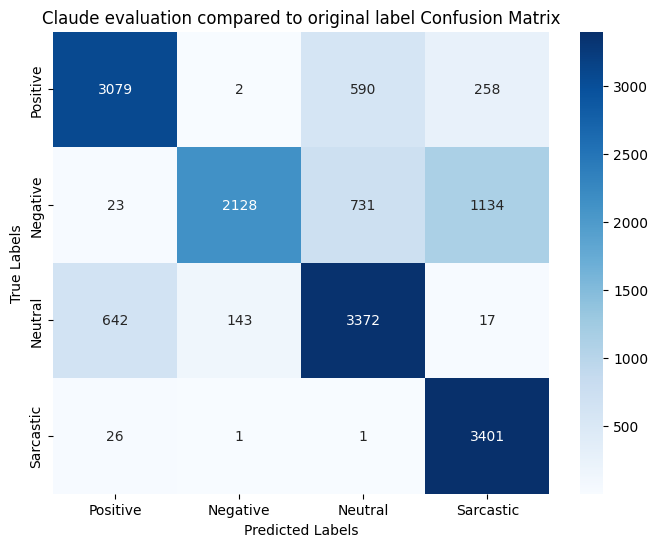

In [22]:
print_analysis_summary(input_file=FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE, caption_label_name='claude_hisia', confusion_matrix_title='Claude evaluation compared to original label Confusion Matrix')

Caption Label: gemini_hisia
Accuracy: 0.7856
Precision for sarcastic_caption: 0.8786
Precision for neutral_caption: 0.6638
Precision for positive_caption: 0.7288
Precision for negative_caption: 0.9118
F1-Score (Macro): 0.7916
F1-Score (Micro): 0.7856
F1-Score (Weighted): 0.7857


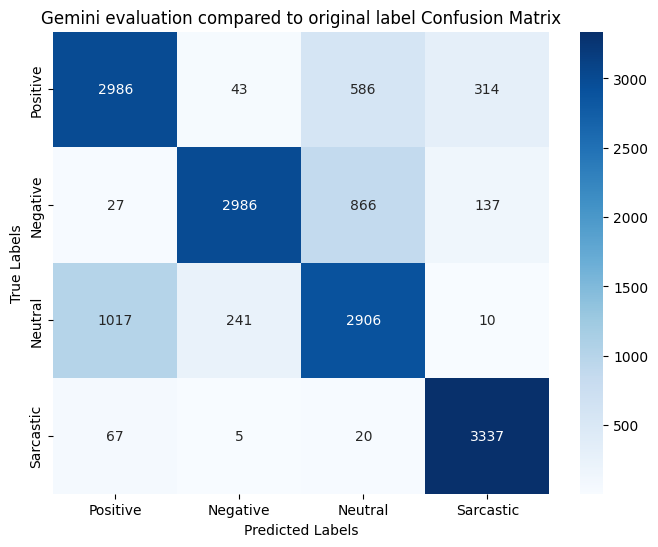

In [23]:
print_analysis_summary(input_file=FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE,caption_label_name='gemini_hisia', confusion_matrix_title='Gemini evaluation compared to original label Confusion Matrix')

In [34]:
import pandas as pd

csv_file = FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE

import pandas as pd


numeric_cols_all = [
    "claude_usahihi_wa_kisarufi",
    "claude_uhusiano_wa_kimuktadha",
    "gemini_usahihi_wa_kisarufi",
    "gemini_uhusiano_wa_kimuktadha"
]

numeric_cols_sarcastic_only = [
    "claude_ubunifu_na_kejeli",
    "gemini_ubunifu_na_kejeli"
]

means_for_all = df[numeric_cols_all].mean(numeric_only=True)


sarcastic_df = df[df["caption_class_label"] == "sarcastic_caption"]
means_for_sarcastic = sarcastic_df[numeric_cols_sarcastic_only].mean(numeric_only=True)


final_means = pd.concat([means_for_all, means_for_sarcastic], axis=0)

print("Final Means:")
print(final_means)


final_means_df = pd.DataFrame(final_means, columns=["mean"]).T
print("\nFinal Means as a 1-row DataFrame:")
print(final_means_df)



Final Means:
claude_usahihi_wa_kisarufi       4.965848
claude_uhusiano_wa_kimuktadha    4.196295
gemini_usahihi_wa_kisarufi       4.962439
gemini_uhusiano_wa_kimuktadha    3.962696
claude_ubunifu_na_kejeli         4.120735
gemini_ubunifu_na_kejeli         3.959463
dtype: float64

Final Means as a 1-row DataFrame:
      claude_usahihi_wa_kisarufi  claude_uhusiano_wa_kimuktadha  \
mean                    4.965848                       4.196295   

      gemini_usahihi_wa_kisarufi  gemini_uhusiano_wa_kimuktadha  \
mean                    4.962439                       3.962696   

      claude_ubunifu_na_kejeli  gemini_ubunifu_na_kejeli  
mean                  4.120735                  3.959463  


In [ ]:
!pip install bert-score


In [ ]:
import pandas as pd
from bert_score import score
import re

BERTSCORE_CAPTIONS_EVALUATION_RESULTS_FILE= "/content/drive/My Drive/DataGeneration/generated_captions/merged/metrics/bertscore_per_category_eval.csv"

# Load dataset
df = pd.read_csv(FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE)

# List of image themes (prefixes)
themes = [
    "wild-fire", "water-disaster", "policy", "plastic-pollution", "oilspill", "non-damage-sea",
    "non-damage-people", "non-damage-forest", "non-damage-buildings-street", "mining", "land-slide",
    "glacier", "forestation", "flooding", "energy", "ecology-damage", "drought", "airpollution", "agriculture"
]

# List of sentiment categories to analyze
sentiments = ["positive_caption", "negative_caption", "sarcastic_caption", "neutral_caption"]

# Store results
results = []
model_name = "xlm-roberta-large"

# Iterate over themes and sentiments
for theme in themes:
    for sentiment in sentiments:
        # Filter dataset where image_id starts with the theme name
        subset = df[df["image_id"].str.startswith(theme, na=False)]
        subset = subset[subset["caption_class_label"] == sentiment]
        print(f" theme {theme} sentiment {sentiment}")
        if len(subset) < 2:
            continue  # Need at least 2 captions to compare

        print(f"subset selected {len(subset)}")

        # Pair adjacent captions as (reference, prediction)
        references = subset["caption"].tolist()[:-1]
        predictions = subset["caption"].tolist()[1:]

        # Compute BERTScore
        P, R, F1 = score(predictions, references, lang="sw", model_type=model_name, verbose=True)

        # Store average scores
        results.append({
            "theme": theme,
            "sentiment": sentiment,
            "bert_precision": P.mean().item(),
            "bert_recall": R.mean().item(),
            "bert_f1": F1.mean().item()
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv(BERTSCORE_CAPTIONS_EVALUATION_RESULTS_FILE, index=False)



In [29]:

# Load the BERTScore results dataset
results_df = pd.read_csv(BERTSCORE_CAPTIONS_EVALUATION_RESULTS_FILE)

# Calculate the average BERTScore for each sentiment
average_scores = results_df.groupby("sentiment")[["bert_precision", "bert_recall", "bert_f1"]].mean()

average_scores.head()

,bert_precision,bert_recall,bert_f1
sentiment,,,
negative_caption,0.885241,0.883656,0.884373
neutral_caption,0.888415,0.887688,0.887977
positive_caption,0.885475,0.885544,0.885452
sarcastic_caption,0.869015,0.866983,0.867926


In [30]:
import pandas as pd
from bert_score import score
from collections import defaultdict

BERTSCORE_NEUTRAL_CAPTION_EVALUATION_RESULTS_FILE= "/content/drive/My Drive/DataGeneration/generated_captions/merged/metrics/bertscore_neutral_caption_eval.csv"

def compute_bertscore_with_neutral_reference(
    df,
    reference_label="neutral_caption",
    target_labels=["positive_caption", "negative_caption", "sarcastic_caption"],
    model_type="xlm-roberta-large"
):
    """
    Computes BERTScore for each target label (e.g. positive, negative, sarcastic),
    using the neutral_caption (reference_label) as reference per image_id.
    Then returns a DataFrame of average precision, recall, and F1 per target label.

    :param df:               Pandas DataFrame with columns:
                               - caption_class_label
                               - image_id
                               - caption
    :param reference_label:  The class label identifying the reference caption (default: "neutral_caption").
    :param target_labels:    List of class labels you want to compare to the reference.
    :param model_type:       The Hugging Face model name for BERTScore (e.g., "bert-base-uncased").
    :return:                 A DataFrame with average precision, recall, and F1 per target label.
    """

    # Dictionary to collect BERTScore results
    # Structure: scores_dict[label]["precision"] => list of float
    scores_dict = defaultdict(lambda: {"precision": [], "recall": [], "f1": []})

    # Group the DataFrame by image_id
    grouped = df.groupby("image_id")

    for image_id, group_df in grouped:
        # 1) Get the reference text (neutral_caption)
        neutral_df = group_df[group_df["caption_class_label"] == reference_label]

        # If no neutral caption, skip this image
        if neutral_df.empty:
            continue

        # We'll take the first neutral_caption as the reference
        reference_text = neutral_df["caption"].iloc[0]

        # 2) For each target label, collect the candidate captions
        for lbl in target_labels:
            candidate_df = group_df[group_df["caption_class_label"] == lbl]
            if candidate_df.empty:
                # No captions of this type for the current image
                continue

            candidates = candidate_df["caption"].dropna().tolist()  # Skip missing captions
            if not candidates:
                continue

            # Prepare references (same neutral reference repeated for each candidate)
            references = [reference_text] * len(candidates)

            # 3) Compute BERTScore using the "score" function
            #    This returns three torch Tensors: (P, R, F1)
            P, R, F1 = score(
                candidates,
                references,
                model_type=model_type
                # You can add other params like `lang="en" or "sw"` if appropriate
            )

            # Convert Tensors to Python lists
            precision_list = P.tolist()
            recall_list    = R.tolist()
            f1_list        = F1.tolist()

            # Store these scores
            scores_dict[lbl]["precision"].extend(precision_list)
            scores_dict[lbl]["recall"].extend(recall_list)
            scores_dict[lbl]["f1"].extend(f1_list)

    # 4) Compute average for each target label
    results = []
    for lbl in target_labels:
        # If we never got any scores for this label, skip it
        if not scores_dict[lbl]["precision"]:
            continue

        # Otherwise, compute mean
        mean_precision = sum(scores_dict[lbl]["precision"]) / len(scores_dict[lbl]["precision"])
        mean_recall    = sum(scores_dict[lbl]["recall"])    / len(scores_dict[lbl]["recall"])
        mean_f1        = sum(scores_dict[lbl]["f1"])        / len(scores_dict[lbl]["f1"])

        results.append({
            "caption_class_label": lbl,
            "precision": mean_precision,
            "recall": mean_recall,
            "f1": mean_f1
        })

    # Convert to DataFrame
    return pd.DataFrame(results)


if __name__ == "__main__":
    # ---------------------------------------------------------------------
    # EXAMPLE USAGE
    # ---------------------------------------------------------------------
    # Load dataset (update path as needed)
    data_csv = FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE
    df = pd.read_csv(data_csv)

    # Compute BERTScore with the specified reference_label
    bertscore_df = compute_bertscore_with_neutral_reference(
        df,
        reference_label="neutral_caption",
        target_labels=["positive_caption", "negative_caption", "sarcastic_caption"],
        model_type="xlm-roberta-large"
    )

    print("BERTScore Averages (Precision, Recall, F1) per Caption Type:")
    print(bertscore_df)

    # Optionally save to CSV
    bertscore_df.to_csv(BERTSCORE_NEUTRAL_CAPTION_EVALUATION_RESULTS_FILE, index=False)


BERTScore Averages (Precision, Recall, F1) per Caption Type:
  caption_class_label  precision    recall        f1
0    positive_caption   0.889261  0.892177  0.890655
1    negative_caption   0.885070  0.888441  0.886693
2   sarcastic_caption   0.864192  0.872263  0.868146


In [35]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
from collections import defaultdict

BLEU_CAPTIONS_EVALUATION_RESULTS_FILE = "/content/drive/My Drive/DataGeneration/generated_captions/merged/metrics/bleu_per_category_eval.csv"

# Load dataset
file_path = FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE
df = pd.read_csv(file_path)
bleu_scores = defaultdict(lambda: defaultdict(list))

smooth_fn = SmoothingFunction().method1  # Use smoothing to handle short sentences

# -------------------------------------------------------
# 2. COMPUTE BLEU SCORES PER THEME & SENTIMENT
# -------------------------------------------------------
for theme in themes:
    # Subset the DataFrame to only rows whose "image_id" starts with the theme
    subset = df[df["image_id"].str.startswith(theme)]

    for sentiment in ["positive_caption", "negative_caption", "neutral_caption", "sarcastic_caption"]:
        # Extract all captions for the given sentiment
        captions = subset[subset["caption_class_label"] == sentiment]["caption"].tolist()

        # Compare each caption pairwise (this is just an example approach)
        for i in range(len(captions) - 1):
            reference = [captions[i].split()]   # tokenize reference
            candidate = captions[i + 1].split() # tokenize candidate

            score = sentence_bleu(reference, candidate, smoothing_function=smooth_fn)
            bleu_scores[theme][sentiment].append(score)

# -------------------------------------------------------
# 3. AVERAGE BLEU PER THEME & SENTIMENT, IGNORING ZEROS
# -------------------------------------------------------
def average_ignoring_zero(scores_list):
    """Return the mean of scores_list, excluding zeros."""
    valid_scores = [s for s in scores_list if s != 0]
    if not valid_scores:
        return 0.0
    return sum(valid_scores) / len(valid_scores)

average_bleu_scores = {}  # Will hold {theme: {sentiment: avg_bleu}}
for theme, sentiments_dict in bleu_scores.items():
    average_bleu_scores[theme] = {}
    for sentiment, scores_list in sentiments_dict.items():
        avg_score = average_ignoring_zero(scores_list)
        average_bleu_scores[theme][sentiment] = avg_score

# -------------------------------------------------------
# 4. BUILD A DATAFRAME (THEMES x SENTIMENTS)
# -------------------------------------------------------
df_bleu = pd.DataFrame(average_bleu_scores).T  # themes as rows, sentiments as columns


# -------------------------------------------------------
# 5. OVERALL AVERAGE BLEU PER SENTIMENT, IGNORING ZEROS
# -------------------------------------------------------
all_scores_by_sentiment = defaultdict(list)
for theme, sentiment_dict in average_bleu_scores.items():
    for sentiment, score in sentiment_dict.items():
        if score != 0:
            all_scores_by_sentiment[sentiment].append(score)

overall_averages = {}
for sentiment, scores in all_scores_by_sentiment.items():
    if not scores:
        overall_averages[sentiment] = 0.0
    else:
        overall_averages[sentiment] = sum(scores) / len(scores)

# Print or convert to DataFrame
# print("Overall Averages Per Sentiment (Ignoring 0):", overall_averages)

df_overall = pd.DataFrame([overall_averages])
df_overall.index = ["Mean BLEU"]
print("\nDataFrame of Overall Averages (Per Sentiment):")

df_overall.to_csv(BLEU_CAPTIONS_EVALUATION_RESULTS_FILE, index=False)

df_overall.head()


DataFrame of Overall Averages (Per Sentiment):


,positive_caption,negative_caption,neutral_caption,sarcastic_caption
Mean BLEU,0.024289,0.024705,0.026866,0.017225


In [ ]:
df_bleu.head(40)

In [36]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict


COSINE_SIMILARITY_CAPTIONS_EVALUATION_RESULTS_FILE= "/content/drive/My Drive/DataGeneration/generated_captions/merged/metrics/cosine_similarity_per_category_eval.csv"
# -------------------------------------------------------
# 1. LOAD DATA
# -------------------------------------------------------
file_path = FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE

df = pd.read_csv(file_path)

themes = [
    "wild-fire", "water-disaster", "policy", "plastic-pollution", "oilspill", "non-damage-sea",
    "non-damage-people", "non-damage-forest", "non-damage-buildings-street", "mining", "land-slide",
    "glacier", "forestation", "flooding", "energy", "ecology-damage", "drought", "airpollution", "agriculture"
]

# A dictionary to store raw cosine similarities for each (theme, sentiment).
cosine_scores = defaultdict(lambda: defaultdict(list))

# -------------------------------------------------------
# 2. HELPER: GET TF-IDF VECTORS
# -------------------------------------------------------
# We will create a single TfidfVectorizer instance.
# You can also do it per (theme, sentiment) subset if needed.
vectorizer = TfidfVectorizer()

def pairwise_cosine_for_captions(captions):
    """
    Given a list of text captions, compute pairwise cosine similarity between
    each caption[i] (as reference) and caption[i+1] (as candidate), returning a list of scores.
    """
    # Fit or transform the entire set of captions to TF-IDF vectors
    # If the corpus is large, you might do vectorizer.fit(...) once overall,
    # then vectorizer.transform(...) here. For a small dataset, this is fine:
    tfidf_matrix = vectorizer.fit_transform(captions)

    # We'll collect pairwise similarity for consecutive caption pairs
    similarities = []
    for i in range(len(captions) - 1):
        # Cosine similarity returns a matrix; we only need the single pair
        vec1 = tfidf_matrix[i]
        vec2 = tfidf_matrix[i + 1]
        sim = cosine_similarity(vec1, vec2)[0, 0]  # [0, 0] extracts the single float
        similarities.append(sim)
    return similarities

# -------------------------------------------------------
# 3. LOOP OVER THEMES & SENTIMENTS TO COLLECT SCORES
# -------------------------------------------------------
for theme in themes:
    # Subset to only rows whose "image_id" starts with the theme
    subset = df[df["image_id"].str.startswith(theme)]

    for sentiment in ["positive_caption", "negative_caption", "neutral_caption", "sarcastic_caption"]:
        # Get all captions for that sentiment
        captions = subset[subset["caption_class_label"] == sentiment]["caption"].tolist()
        if len(captions) > 1:
            # Compute pairwise similarity scores
            scores = pairwise_cosine_for_captions(captions)
            cosine_scores[theme][sentiment].extend(scores)
        else:
            # Not enough captions to form a pair
            cosine_scores[theme][sentiment].extend([])

# -------------------------------------------------------
# 4. AVERAGE COSINE SIM PER THEME & SENTIMENT (IGNORE 0s)
# -------------------------------------------------------
def average_ignoring_zero(scores_list):
    """Return the mean of scores_list, excluding zero values."""
    valid_scores = [s for s in scores_list if s != 0]
    if not valid_scores:
        return 0.0
    return sum(valid_scores) / len(valid_scores)

average_cosine_scores = {}  # {theme: {sentiment: avg_cosine}}
for theme, sentiments_dict in cosine_scores.items():
    average_cosine_scores[theme] = {}
    for sentiment, scores_list in sentiments_dict.items():
        avg_score = average_ignoring_zero(scores_list)
        average_cosine_scores[theme][sentiment] = avg_score

# -------------------------------------------------------
# 5. BUILD A DATAFRAME (THEMES x SENTIMENTS)
# -------------------------------------------------------
df_cosine = pd.DataFrame(average_cosine_scores).T

# -------------------------------------------------------
# 6. COMPUTE OVERALL AVERAGE PER SENTIMENT, IGNORING 0
# -------------------------------------------------------
from collections import defaultdict

all_scores_by_sentiment = defaultdict(list)
for theme, sentiment_dict in average_cosine_scores.items():
    for sentiment, score in sentiment_dict.items():
        if score != 0:
            all_scores_by_sentiment[sentiment].append(score)

overall_averages = {}
for sentiment, scores in all_scores_by_sentiment.items():
    if len(scores) == 0:
        overall_averages[sentiment] = 0.0
    else:
        overall_averages[sentiment] = sum(scores) / len(scores)

print("Overall Cosine Similarity Averages (Ignoring 0):", overall_averages)

# Optionally convert to a DataFrame
df_overall = pd.DataFrame([overall_averages])
df_overall.index = ["Mean Cosine"]
print("\nDataFrame of Overall Averages (Per Sentiment):")

df_overall.to_csv(COSINE_SIMILARITY_CAPTIONS_EVALUATION_RESULTS_FILE, index=False)

df_overall.head()

Overall Cosine Similarity Averages (Ignoring 0): {'positive_caption': 0.09148397269364374, 'negative_caption': 0.10585953443979705, 'neutral_caption': 0.09562824860543186, 'sarcastic_caption': 0.07644886461220066}

DataFrame of Overall Averages (Per Sentiment):


,positive_caption,negative_caption,neutral_caption,sarcastic_caption
Mean Cosine,0.091484,0.10586,0.095628,0.076449


## Final Swahili dataset

In [8]:
import pandas as pd

SWAHILI_MULTIMODAL_SARACSM_DATASET= "/content/drive/My Drive/DataGeneration/generated_captions/merged/swahili_multimodal_sarcasm_dataset.csv"

# 1. Read the CSV file into a DataFrame.
swahili_df = pd.read_csv(FINAL_COMBINED_CAPTIONS_EVALUATION_RESULTS_FILE)


swahili_df["image_path"] = swahili_df["image_id"].str.replace("_", "/", 1)


# 2. Create a dictionary to map the English labels to Swahili
translation_map = {
    "positive": "chanya",
    "negative": "hasi",
    "neutral": "upande_wowote",
    "sarcastic": "kejeli"
}



# 3. Replace values in 'caption_class_label' using our translation map
swahili_df["caption_class_label"] = swahili_df["caption_class_label"].replace(translation_map)

swahili_df.rename(columns={
    "caption": "sentensi",
    "tags": "vitambulisho",
    "caption_class_label": "hisia"
}, inplace=True)

swahili_df = swahili_df[["caption_id", "image_path","hisia",  "sentensi", "vitambulisho"]]

# 3. (Optional) Write the updated DataFrame to a new CSV file.
swahili_df.to_csv(SWAHILI_MULTIMODAL_SARACSM_DATASET, index=False)

swahili_df.head()


,caption_id,image_path,hisia,sentensi,vitambulisho
0,0,non-damage-sea/06_04_0822.png,sarcastic_caption,"Ah, upeo wa bahari ni wa kusisimua sana! Bora ...","bahari tulivu, upeo, anga tulivu, asili, utulivu"
1,1,non-damage-sea/06_04_0822.png,neutral_caption,Bahari tulivu inafika upeo chini ya anga tuliv...,"bahari tulivu, upeo, anga tulivu, asili, utulivu"
2,2,non-damage-sea/06_04_0822.png,positive_caption,Mandhari tulivu ya bahari yanakaribisha fikira...,"bahari tulivu, upeo, anga tulivu, asili, utulivu"
3,3,non-damage-sea/06_04_0822.png,negative_caption,"Siku inavyokuchwa juu ya bahari, tunakumbushwa...","bahari tulivu, upeo, anga tulivu, asili, utulivu"
4,4,non-damage-sea/06_04_0611.png,sarcastic_caption,"Ona, msafara wa meli ukihakikisha bahari zetu ...","meli za kivita, uchafuzi wa bahari"


In [16]:

import pandas as pd

SWAHILI_MULTIMODAL_SARACSM_IMAGES= "/content/drive/My Drive/DataGeneration/generated_captions/merged/image_paths.txt"

df = pd.read_csv(SWAHILI_MULTIMODAL_SARACSM_DATASET)

# 2. Choose the column that contains your image paths
image_paths = df["image_path"].unique()  # or df["image_path"] if that's your column name

# 3. Write each path on its own line to "image_paths.txt"
with open(SWAHILI_MULTIMODAL_SARACSM_IMAGES, "w") as f:
    for path in image_paths:
        f.write(path + "\n")

print(len(image_paths))

print("All image paths have been written to image_paths.txt")

5796
All image paths have been written to image_paths.txt
